# __Machine Learning for Prioritizing Blood Pressure Genes__ 

In [1]:
import re

import numpy as np
import pandas as pd
import scipy.cluster
from numpy import absolute, mean, sort, std
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

import matplotlib.pylab as plt
import seaborn as sns
import shap
import statsmodels.api as sm

%matplotlib inline
%config InlineBackend.figure_format ='retina'
import xgboost

from matplotlib.pyplot import cm
from sklearn import datasets, metrics, model_selection, preprocessing
from sklearn.metrics import *
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    LeaveOneOut,
    RandomizedSearchCV,
    RepeatedKFold,
    cross_val_predict,
    cross_validate,
    learning_curve,
    train_test_split,
    validation_curve,
    StratifiedKFold
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import class_weight
from skopt import BayesSearchCV
from skopt.plots import plot_convergence


import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
from missingpy import MissForest


sns.set_style("darkgrid")


import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
from warnings import filterwarnings

filterwarnings("ignore")

seed = 0

In [2]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")
Y_label = data[["Gene", "BPlabel"]]

In [3]:
data["BPlabel_encoded"] = data["BPlabel"].map(
    {'most likely':0,'probable':1, 'least likely':2}
)
Y = data["BPlabel_encoded"]
classes_weights_all = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=Y
)
data = data.drop(["BPlabel"], 1)
data.shape

(293, 22)

### Load Boruta Shap Feature Selected Features

In [4]:
X = pd.read_csv("selected_features_training_data.csv", header=0)
X.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

In [5]:
df_gene = data[["Gene"]]

X_genes = pd.concat([df_gene, X], axis=1)

X_genes = X_genes.set_index("Gene")

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, test_size=0.2, random_state=0
)


In [12]:
classes_weights_train = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=Y_train
)

In [8]:
# Model parameters built from repeated nested CV benchmarking
xgb = xgboost.XGBClassifier(random_state=seed, objective='reg:squarederror',
                             learning_rate = 0.2,
                             max_depth = 4,
                             n_estimators=50,
                             reg_alpha=1,
                             reg_lambda=1,
                             verbosity = 0, eval_metric='mlogloss', scale_pos_weight=0.21) 

In [13]:
target_names = ['most likely', 'probable', 'least likely']

xgb.fit(X_train, Y_train, sample_weight=classes_weights_train)
predictions = list(xgb.predict(X_test))
print(classification_report(Y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

 most likely       0.29      0.57      0.38         7
    probable       0.79      0.69      0.73        32
least likely       1.00      0.85      0.92        20

    accuracy                           0.73        59
   macro avg       0.69      0.70      0.68        59
weighted avg       0.80      0.73      0.75        59



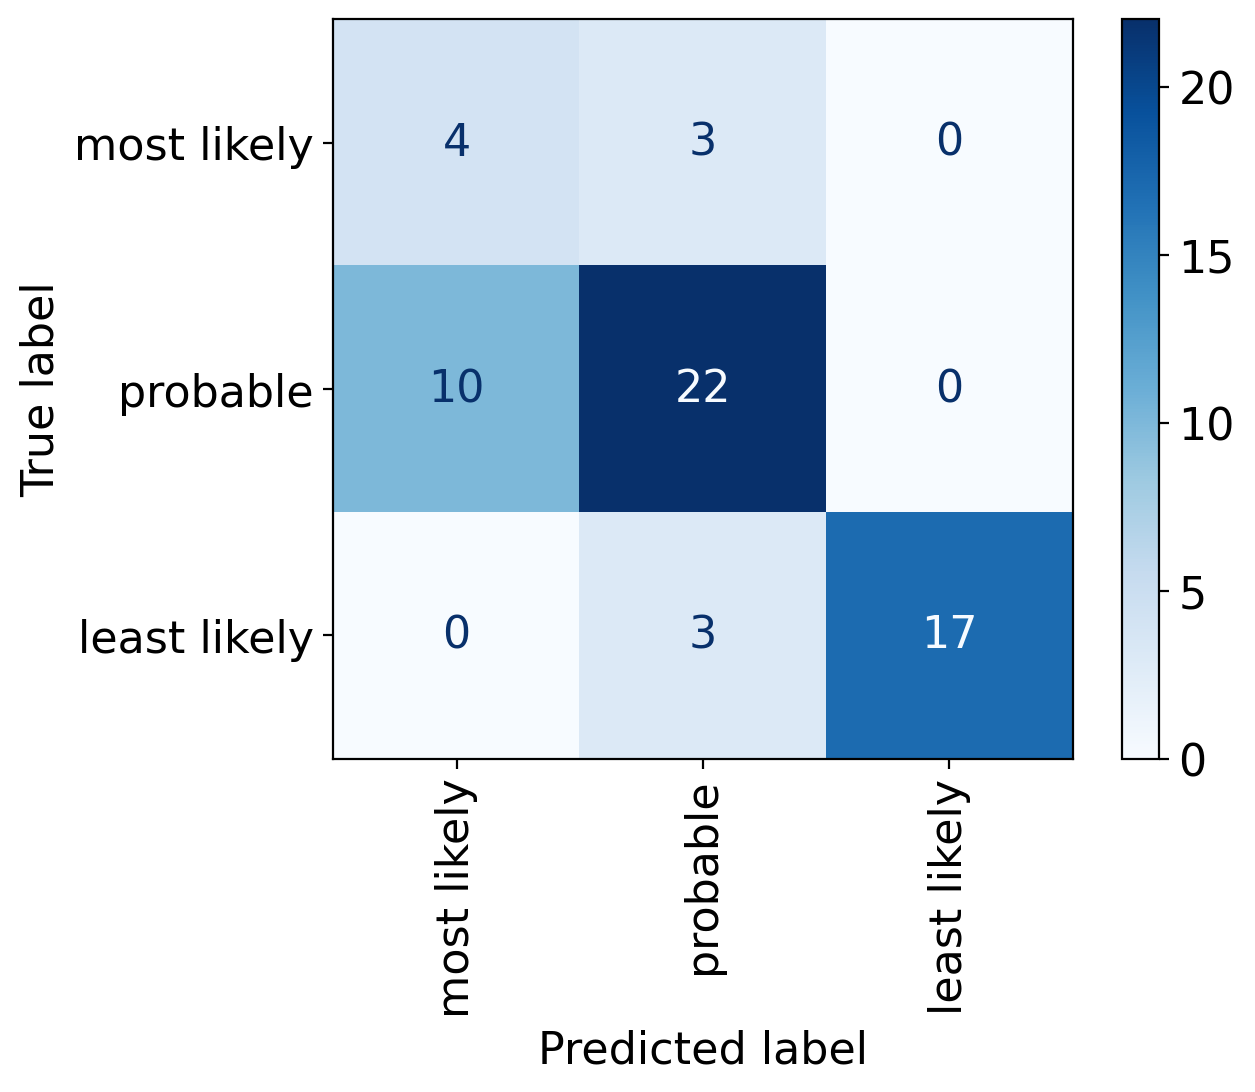

In [14]:
xgb.fit(X_train, Y_train, sample_weight=classes_weights_train)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.size"] = "16"
class_names = ['most likely', 'probable', 'least likely']
%matplotlib inline
disp = plot_confusion_matrix(xgb, X_test, Y_test, display_labels=class_names, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.savefig('confusion_cb_train.png', format='png', dpi=300, bbox_inches = "tight")

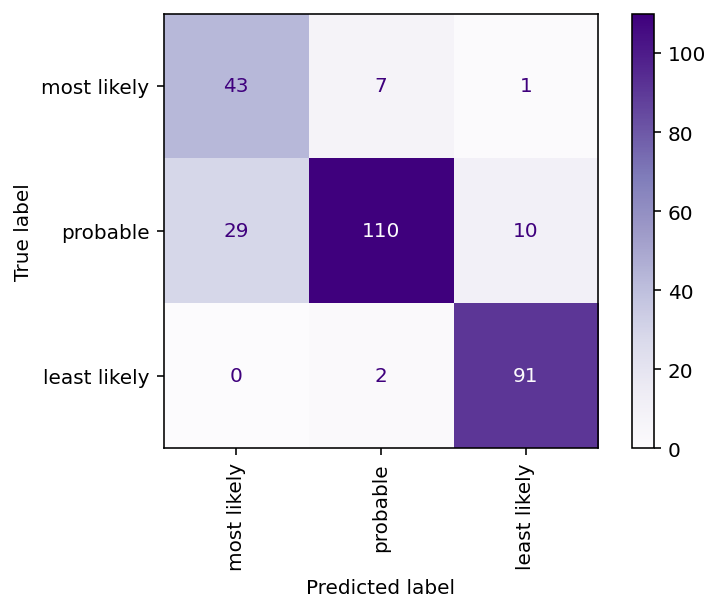

In [172]:
cal_clf.fit(X, Y, sample_weight=classes_weights_all)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams["font.size"] = "16"
class_names = ['most likely', 'probable', 'least likely']
%matplotlib inline
disp = plot_confusion_matrix(cal_clf, X, Y, display_labels=class_names, cmap=plt.cm.Purples, xticks_rotation='vertical')
plt.savefig('confusion_cb_all.png', format='png', dpi=300, bbox_inches = "tight")

### Training Data Prediction Visualization:

In [16]:
predictions = list(xgb.predict(X))

output = pd.Series(data=predictions, index=X_genes.index, name="xgb_label")

output = output.to_frame()
output.reset_index(level=0, inplace=True)

output

Gene  xgb_label
0         ABCC9          0
1    AC006455.1          2
2    AC007216.2          2
3    AC007461.1          2
4    AC008498.1          2
..          ...        ...
288        YES1          1
289    Z98049.1          2
290       ZAP70          1
291     ZMYM6NB          2
292     ZSCAN5D          2

[293 rows x 2 columns]

In [17]:
data = pd.read_csv("training_cleaned.csv", header=0, sep=",")
data["BPlabel_encoded"] = data["BPlabel"].map(
    {'most likely':0,'probable':1, 'least likely':2}
)
df_b = data[["BPlabel_encoded"]]

df_c = pd.concat([output, df_b], axis=1)
df_c

Gene  xgb_label  BPlabel_encoded
0         ABCC9          0                0
1    AC006455.1          2                2
2    AC007216.2          2                2
3    AC007461.1          2                2
4    AC008498.1          2                2
..          ...        ...              ...
288        YES1          1                1
289    Z98049.1          2                2
290       ZAP70          1                1
291     ZMYM6NB          2                2
292     ZSCAN5D          2                2

[293 rows x 3 columns]

### SHAP Feature Importance Visualization:

In [20]:
class_names = ['most likely','probable', 'least likely']
xgb.fit(X_train, Y_train,sample_weight=classes_weights_train)
df3 = pd.DataFrame(data=X, columns=X.columns)
df3.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]
X_importance = X_test
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_importance)
X_importance = pd.DataFrame(data=X_test, columns=df3.columns)

## Shap Summary Plot for All Classes

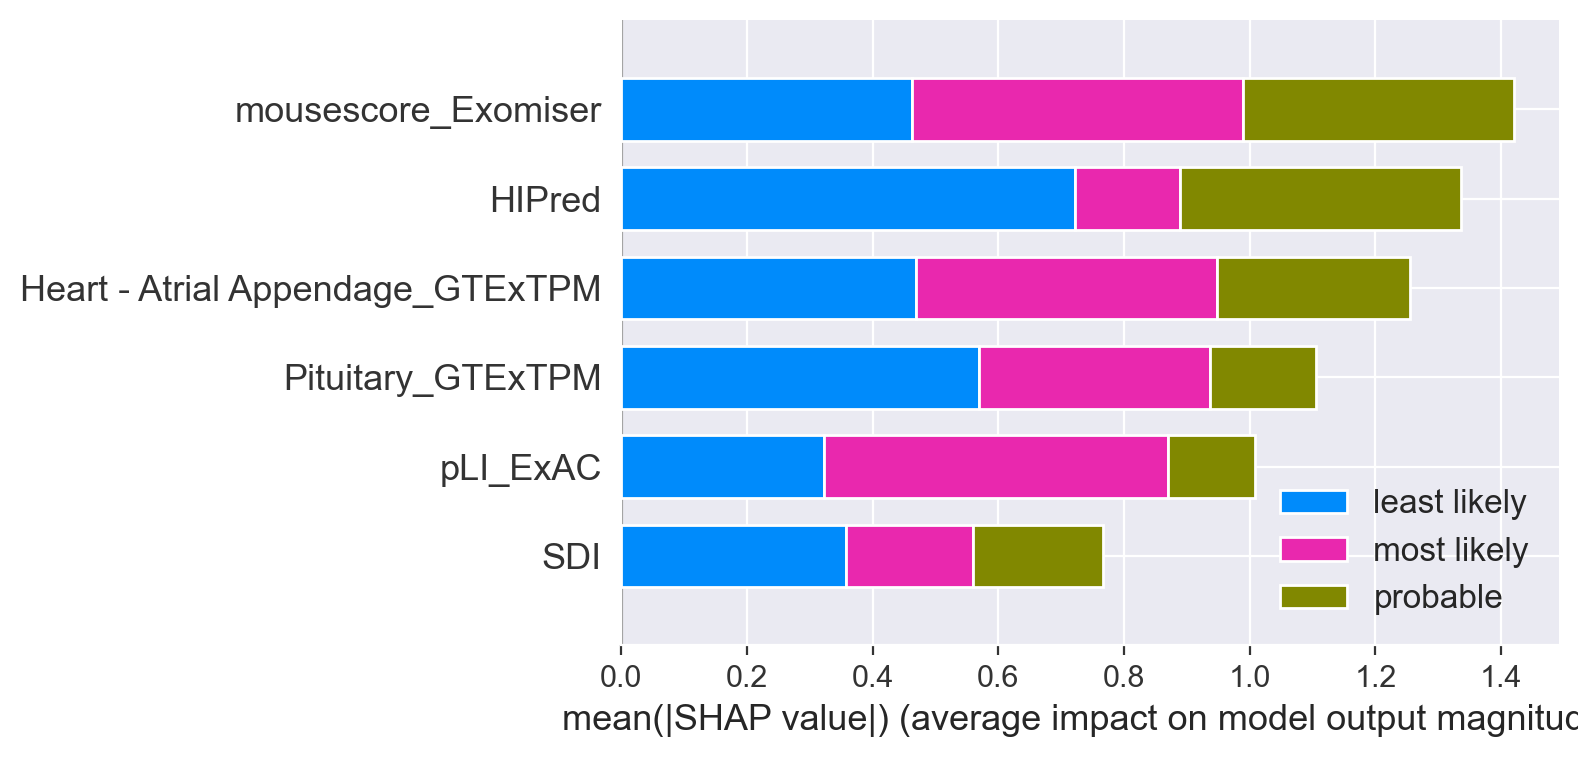

In [21]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values, X_importance, class_names = class_names)
fig.savefig('shap_summary.png', format='png', dpi=300, bbox_inches = "tight")

# Shap Summary Plot for 51 Most Likely BP Genes

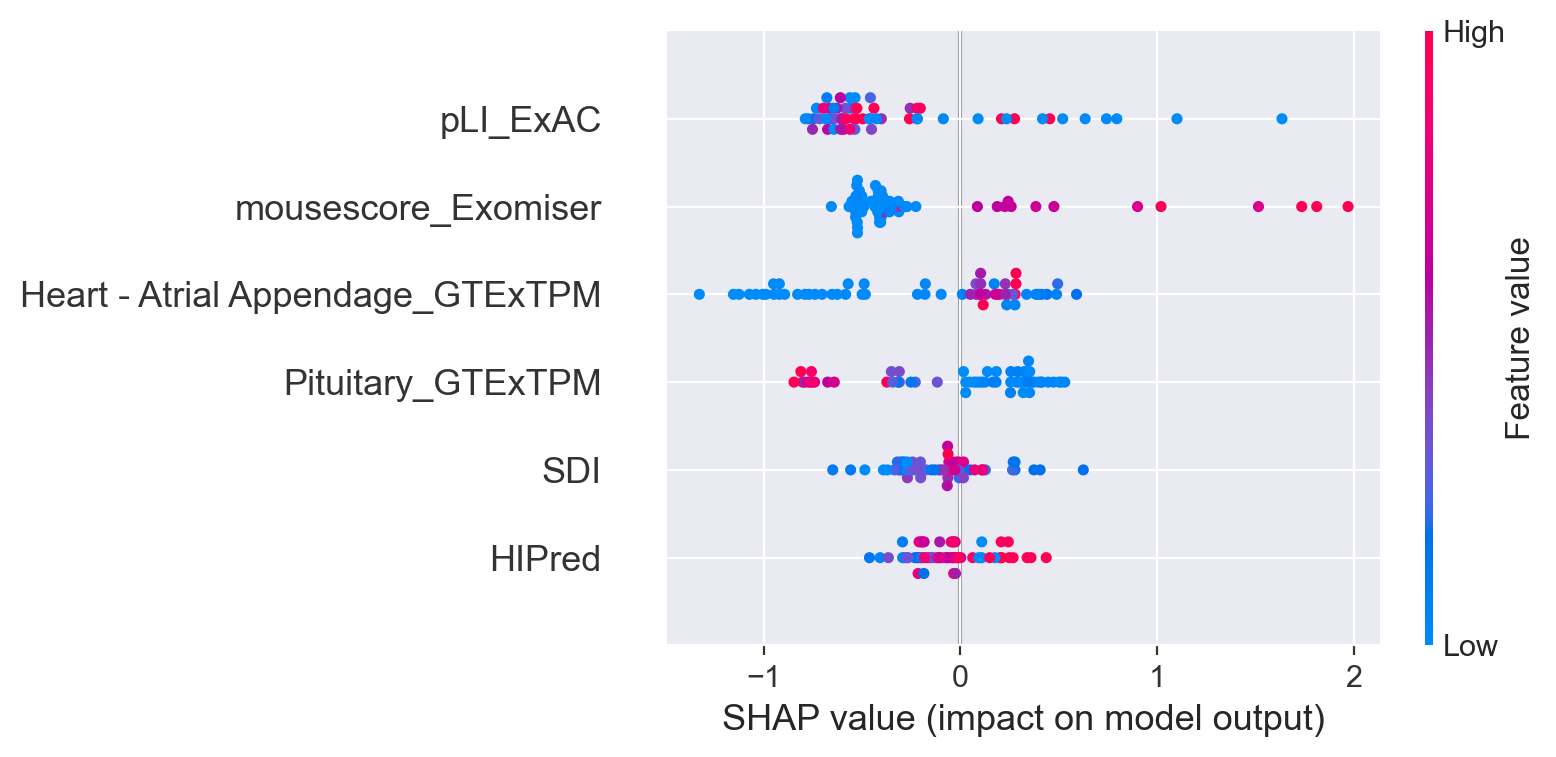

In [22]:
sns.set_style("darkgrid")
fig, ax = plt.subplots()
shap.summary_plot(shap_values[0], X_importance, feature_names = X_importance.columns)
fig.savefig('shap_summary_most_likely.png', format='png', dpi=300, bbox_inches = "tight")

# Shap Summary Plot for 149 Probable BP Genes

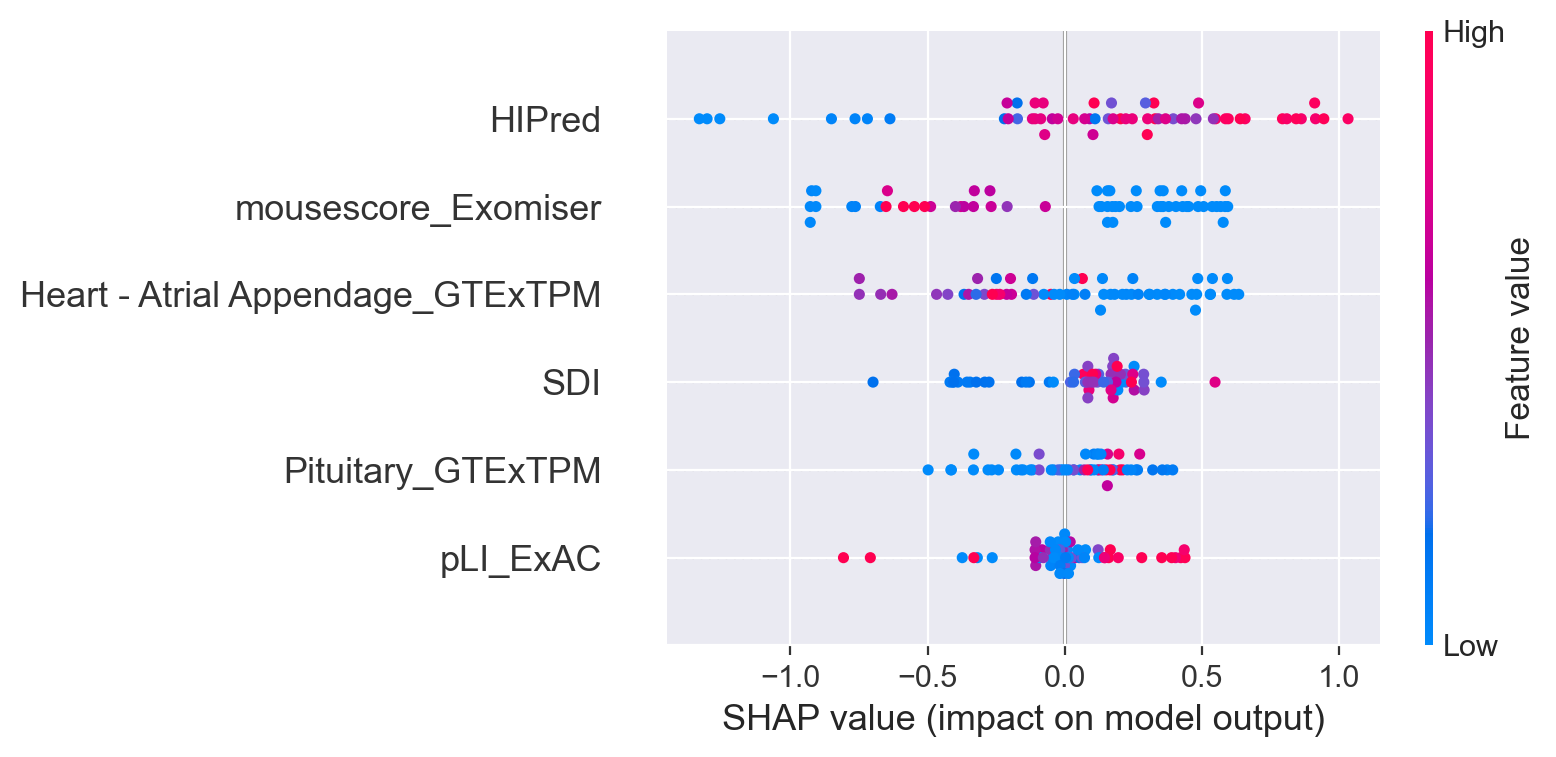

In [23]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values[1], X_importance, feature_names = X_importance.columns)
fig.savefig('shap_summary_probable.png', format='png', dpi=300, bbox_inches = "tight")

# Shap Summary Plot for 93 Least Likely BP Genes

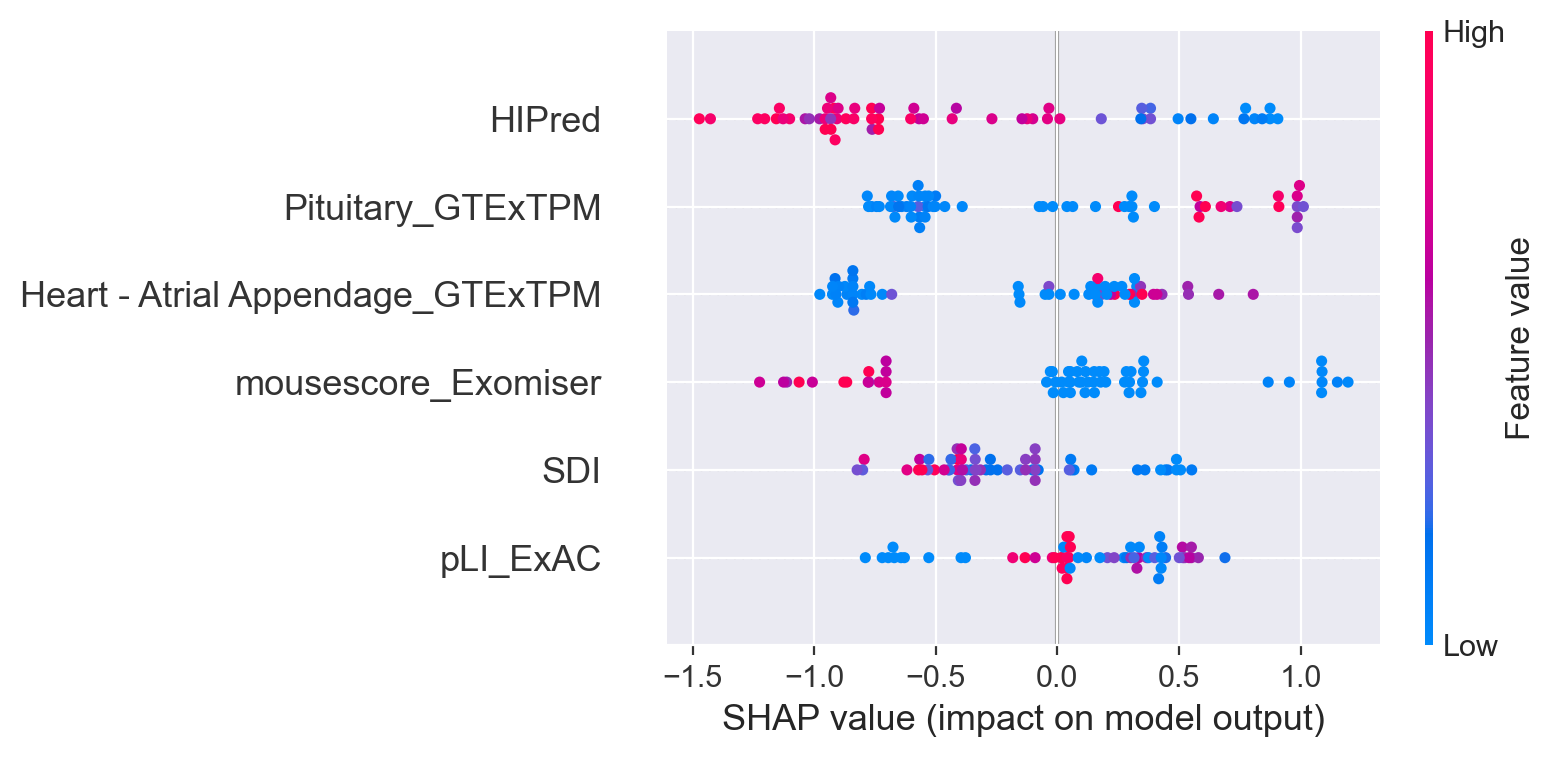

In [24]:
fig, ax = plt.subplots()
shap.summary_plot(shap_values[2], X_importance, feature_names = X_importance.columns)
fig.savefig('shap_summary_least_likely.png', format='png', dpi=300, bbox_inches = "tight")

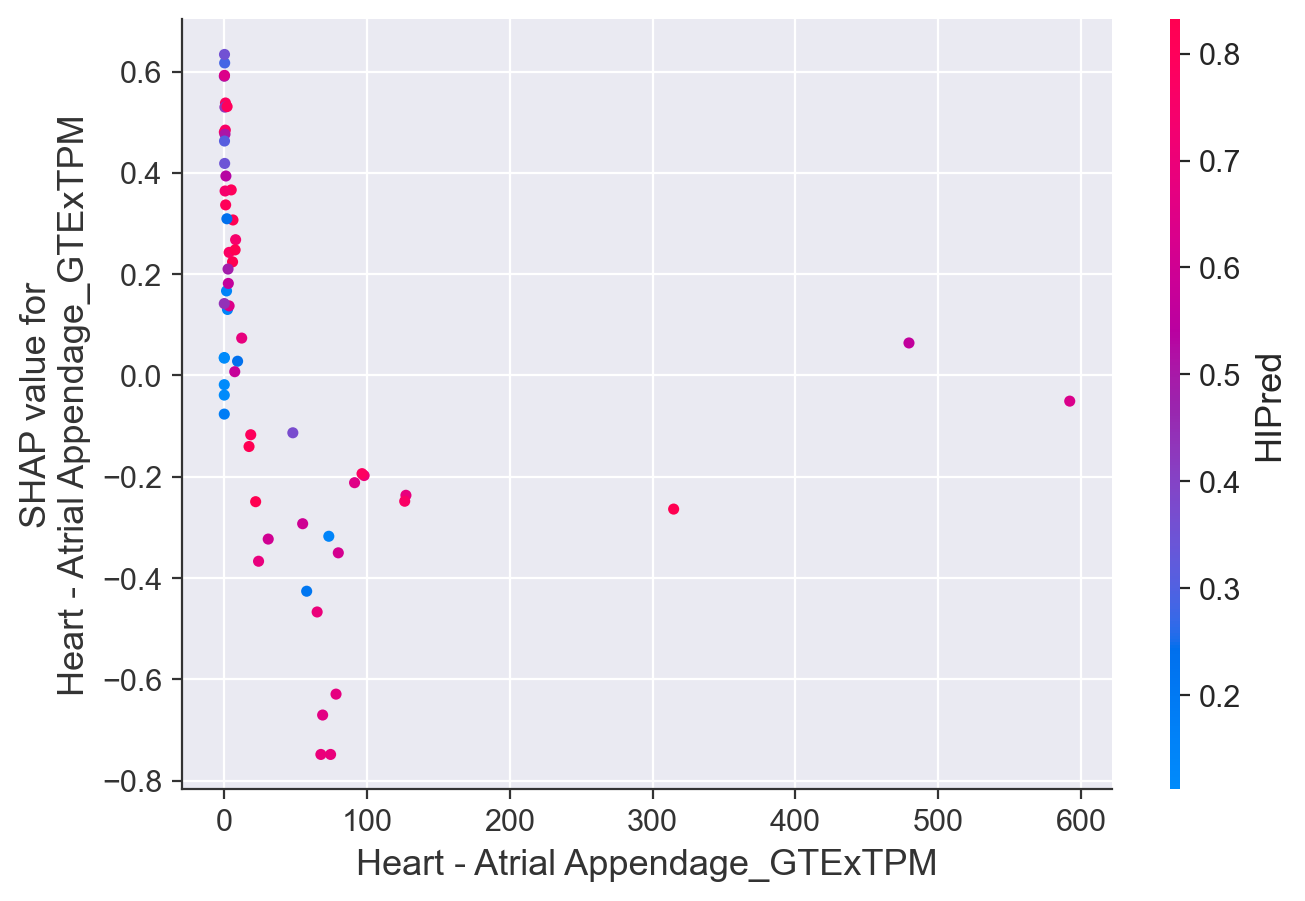

In [27]:
shap.dependence_plot(1, shap_values[1], X_importance.values, feature_names=X_importance.columns)

In [28]:
expected_value = explainer.expected_value
if isinstance(expected_value, list):
    expected_value = expected_value[1]
print(f"Explainer expected value: {expected_value}")

Explainer expected value: 0.667179524898529


In [30]:
shap_interaction_values = explainer.shap_interaction_values(X)

In [31]:
plt.rcParams.update(plt.rcParamsDefault)
X_interaction = pd.DataFrame(data=X, columns=X.columns)

sns.set_style("darkgrid")
tmp = np.abs(shap_interaction_values[0]).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]


f = plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  
plt.yticks(
    range(tmp2.shape[0]),
    labels=(X.columns),
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    labels=(X.columns),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()
f.savefig("shap_interactions_ml.png", format='png', dpi=300)


#plt.show()


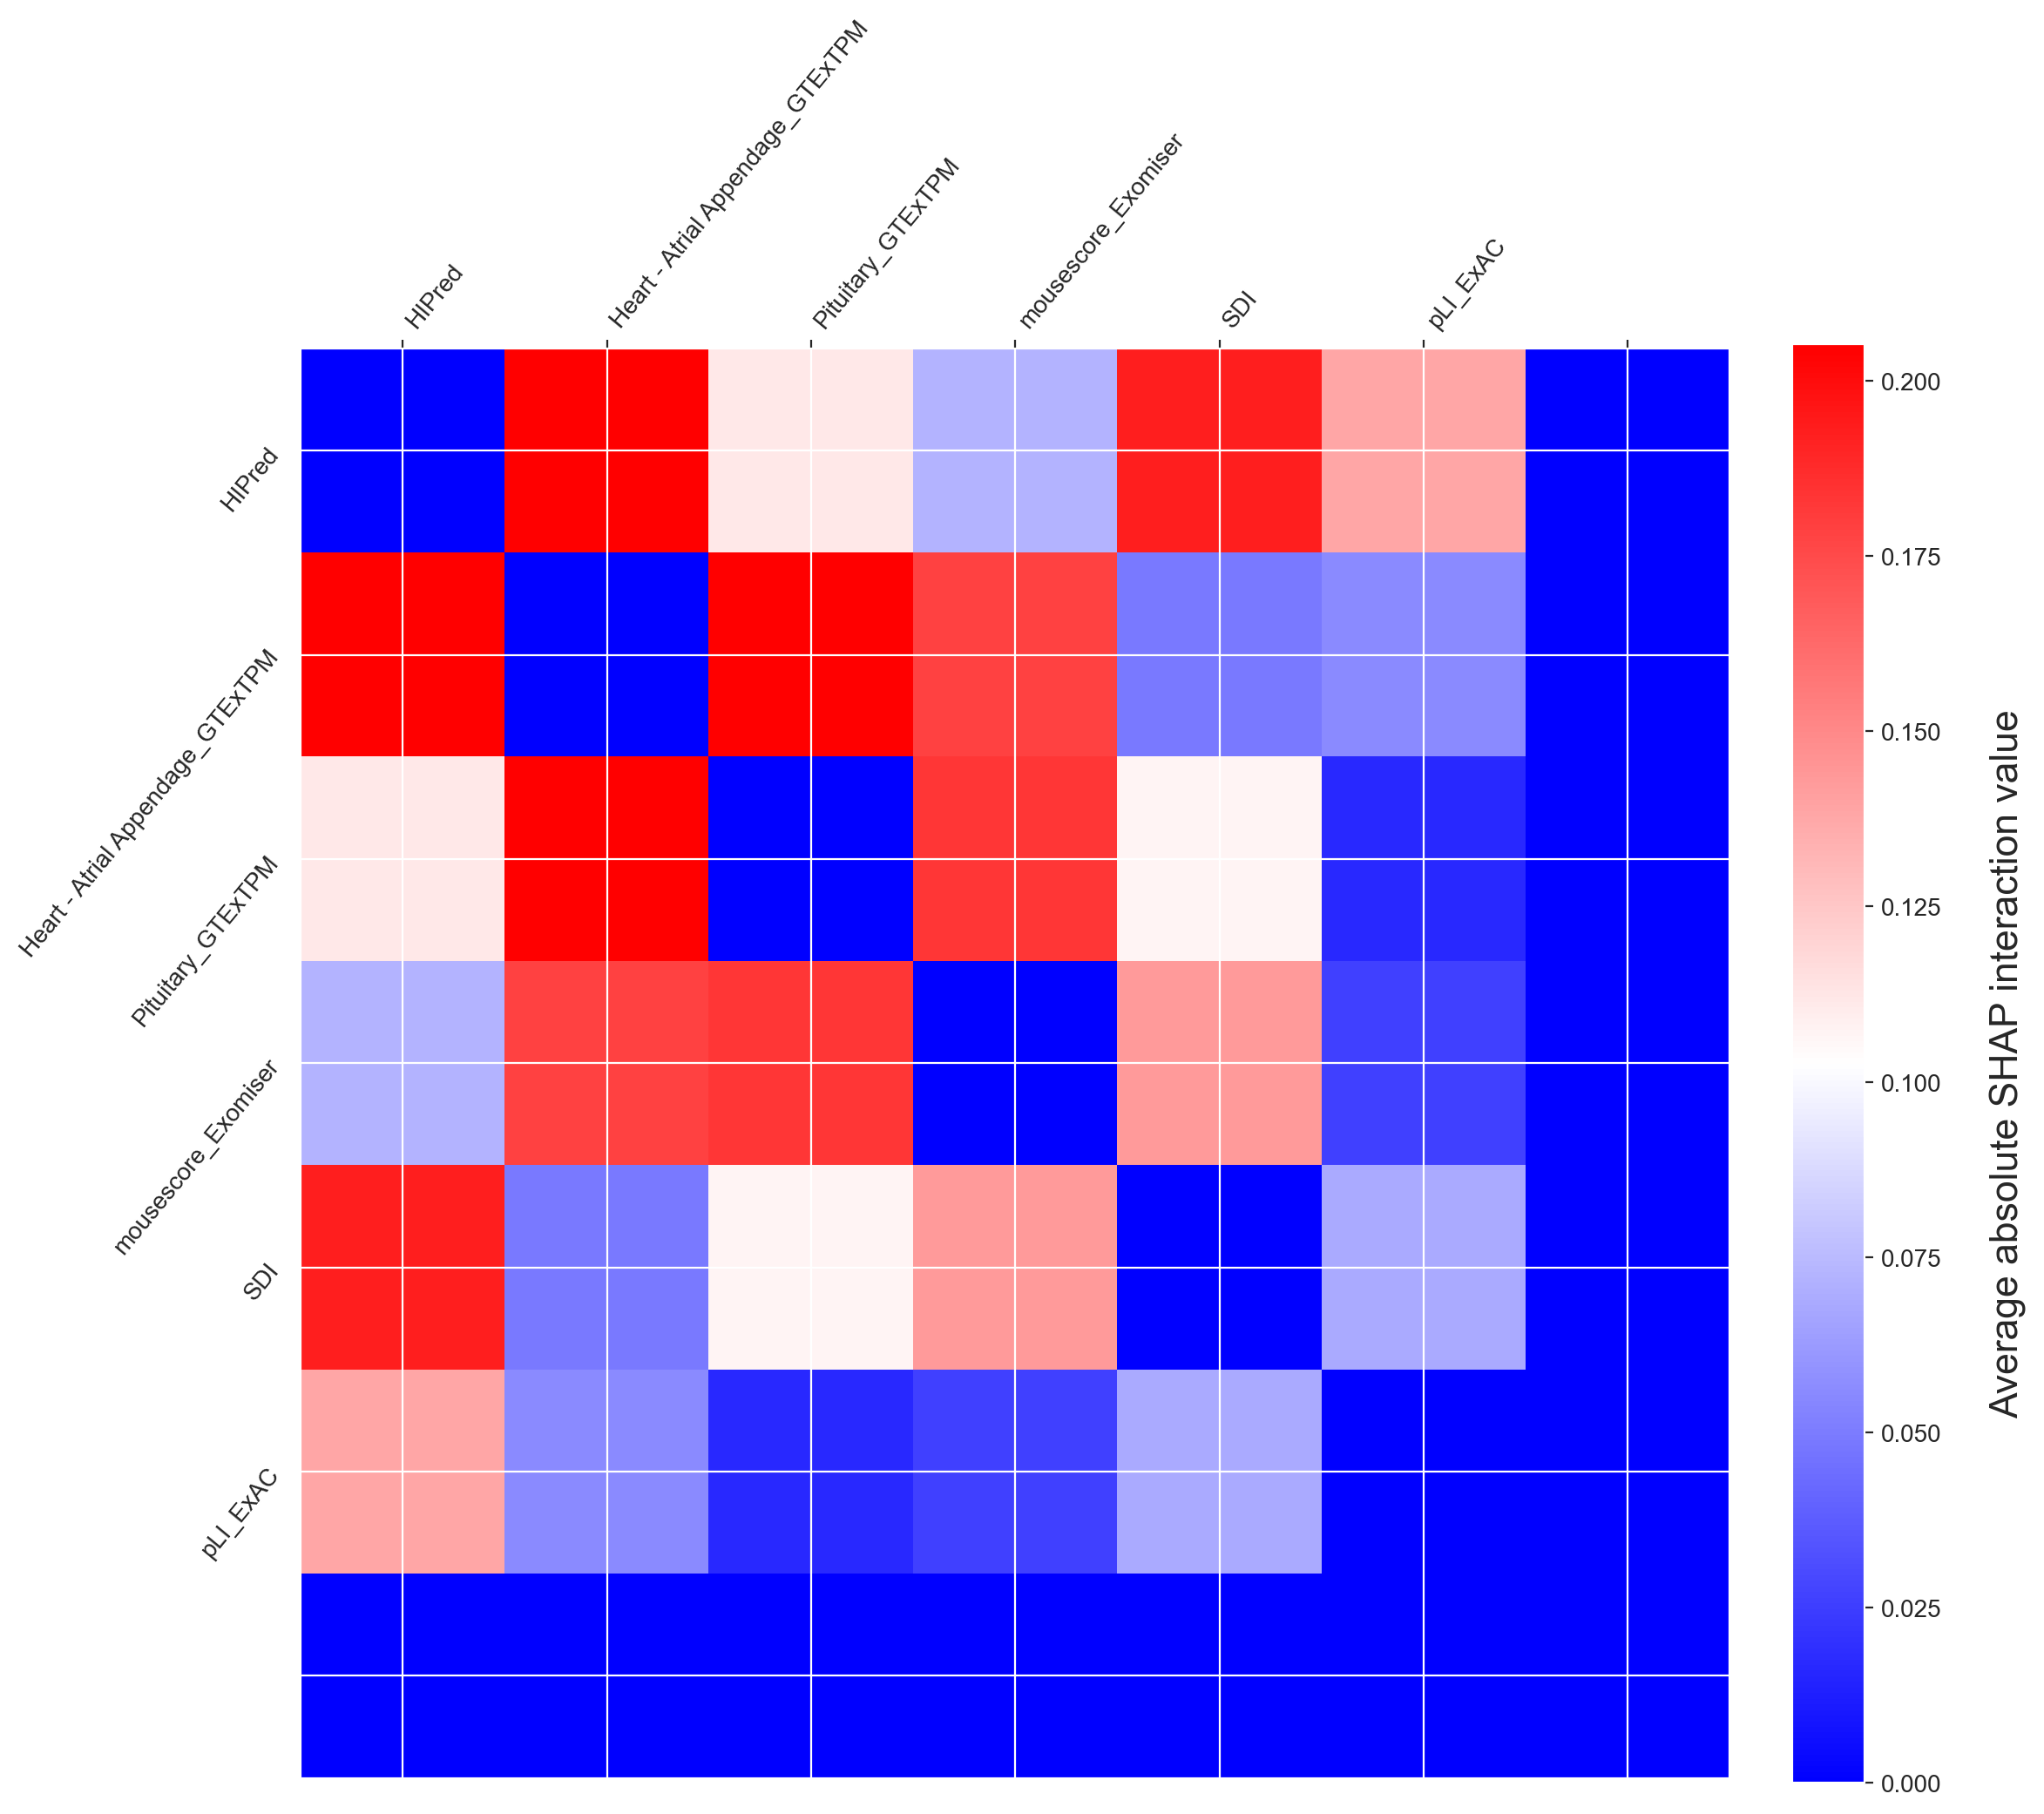

In [246]:
plt.rcParams.update(plt.rcParamsDefault)
X_interaction = pd.DataFrame(data=X, columns=X.columns)

sns.set_style("darkgrid")
tmp = np.abs(shap_interaction_values[1]).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]


f = plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  
plt.yticks(
    range(tmp2.shape[0]),
    labels=(X.columns),
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    labels=(X.columns),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()
f.savefig("shap_interactions_probable.png", format='png', dpi=300)


#plt.show()


In [32]:
plt.rcParams.update(plt.rcParamsDefault)
X_interaction = pd.DataFrame(data=X, columns=X.columns)

sns.set_style("darkgrid")
tmp = np.abs(shap_interaction_values[2]).sum(0)
for i in range(tmp.shape[0]):
    tmp[i, i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds, :][:, inds]


f = plt.figure(figsize=(12, 12))
plt.imshow(
    tmp2, cmap="bwr"
)  
plt.yticks(
    range(tmp2.shape[0]),
    labels=(X.columns),
    rotation=50.4,
    horizontalalignment="right",
)
plt.xticks(
    range(tmp2.shape[0]),
    labels=(X.columns),
    rotation=50.4,
    horizontalalignment="left",
)
plt.gca().xaxis.tick_top()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.set_label("Average absolute SHAP interaction value", size=16, labelpad=20)
plt.rcParams.update({"font.size": 16})
plt.tight_layout()
f.savefig("shap_interactions_ll.png", format='png', dpi=300)


#plt.show()


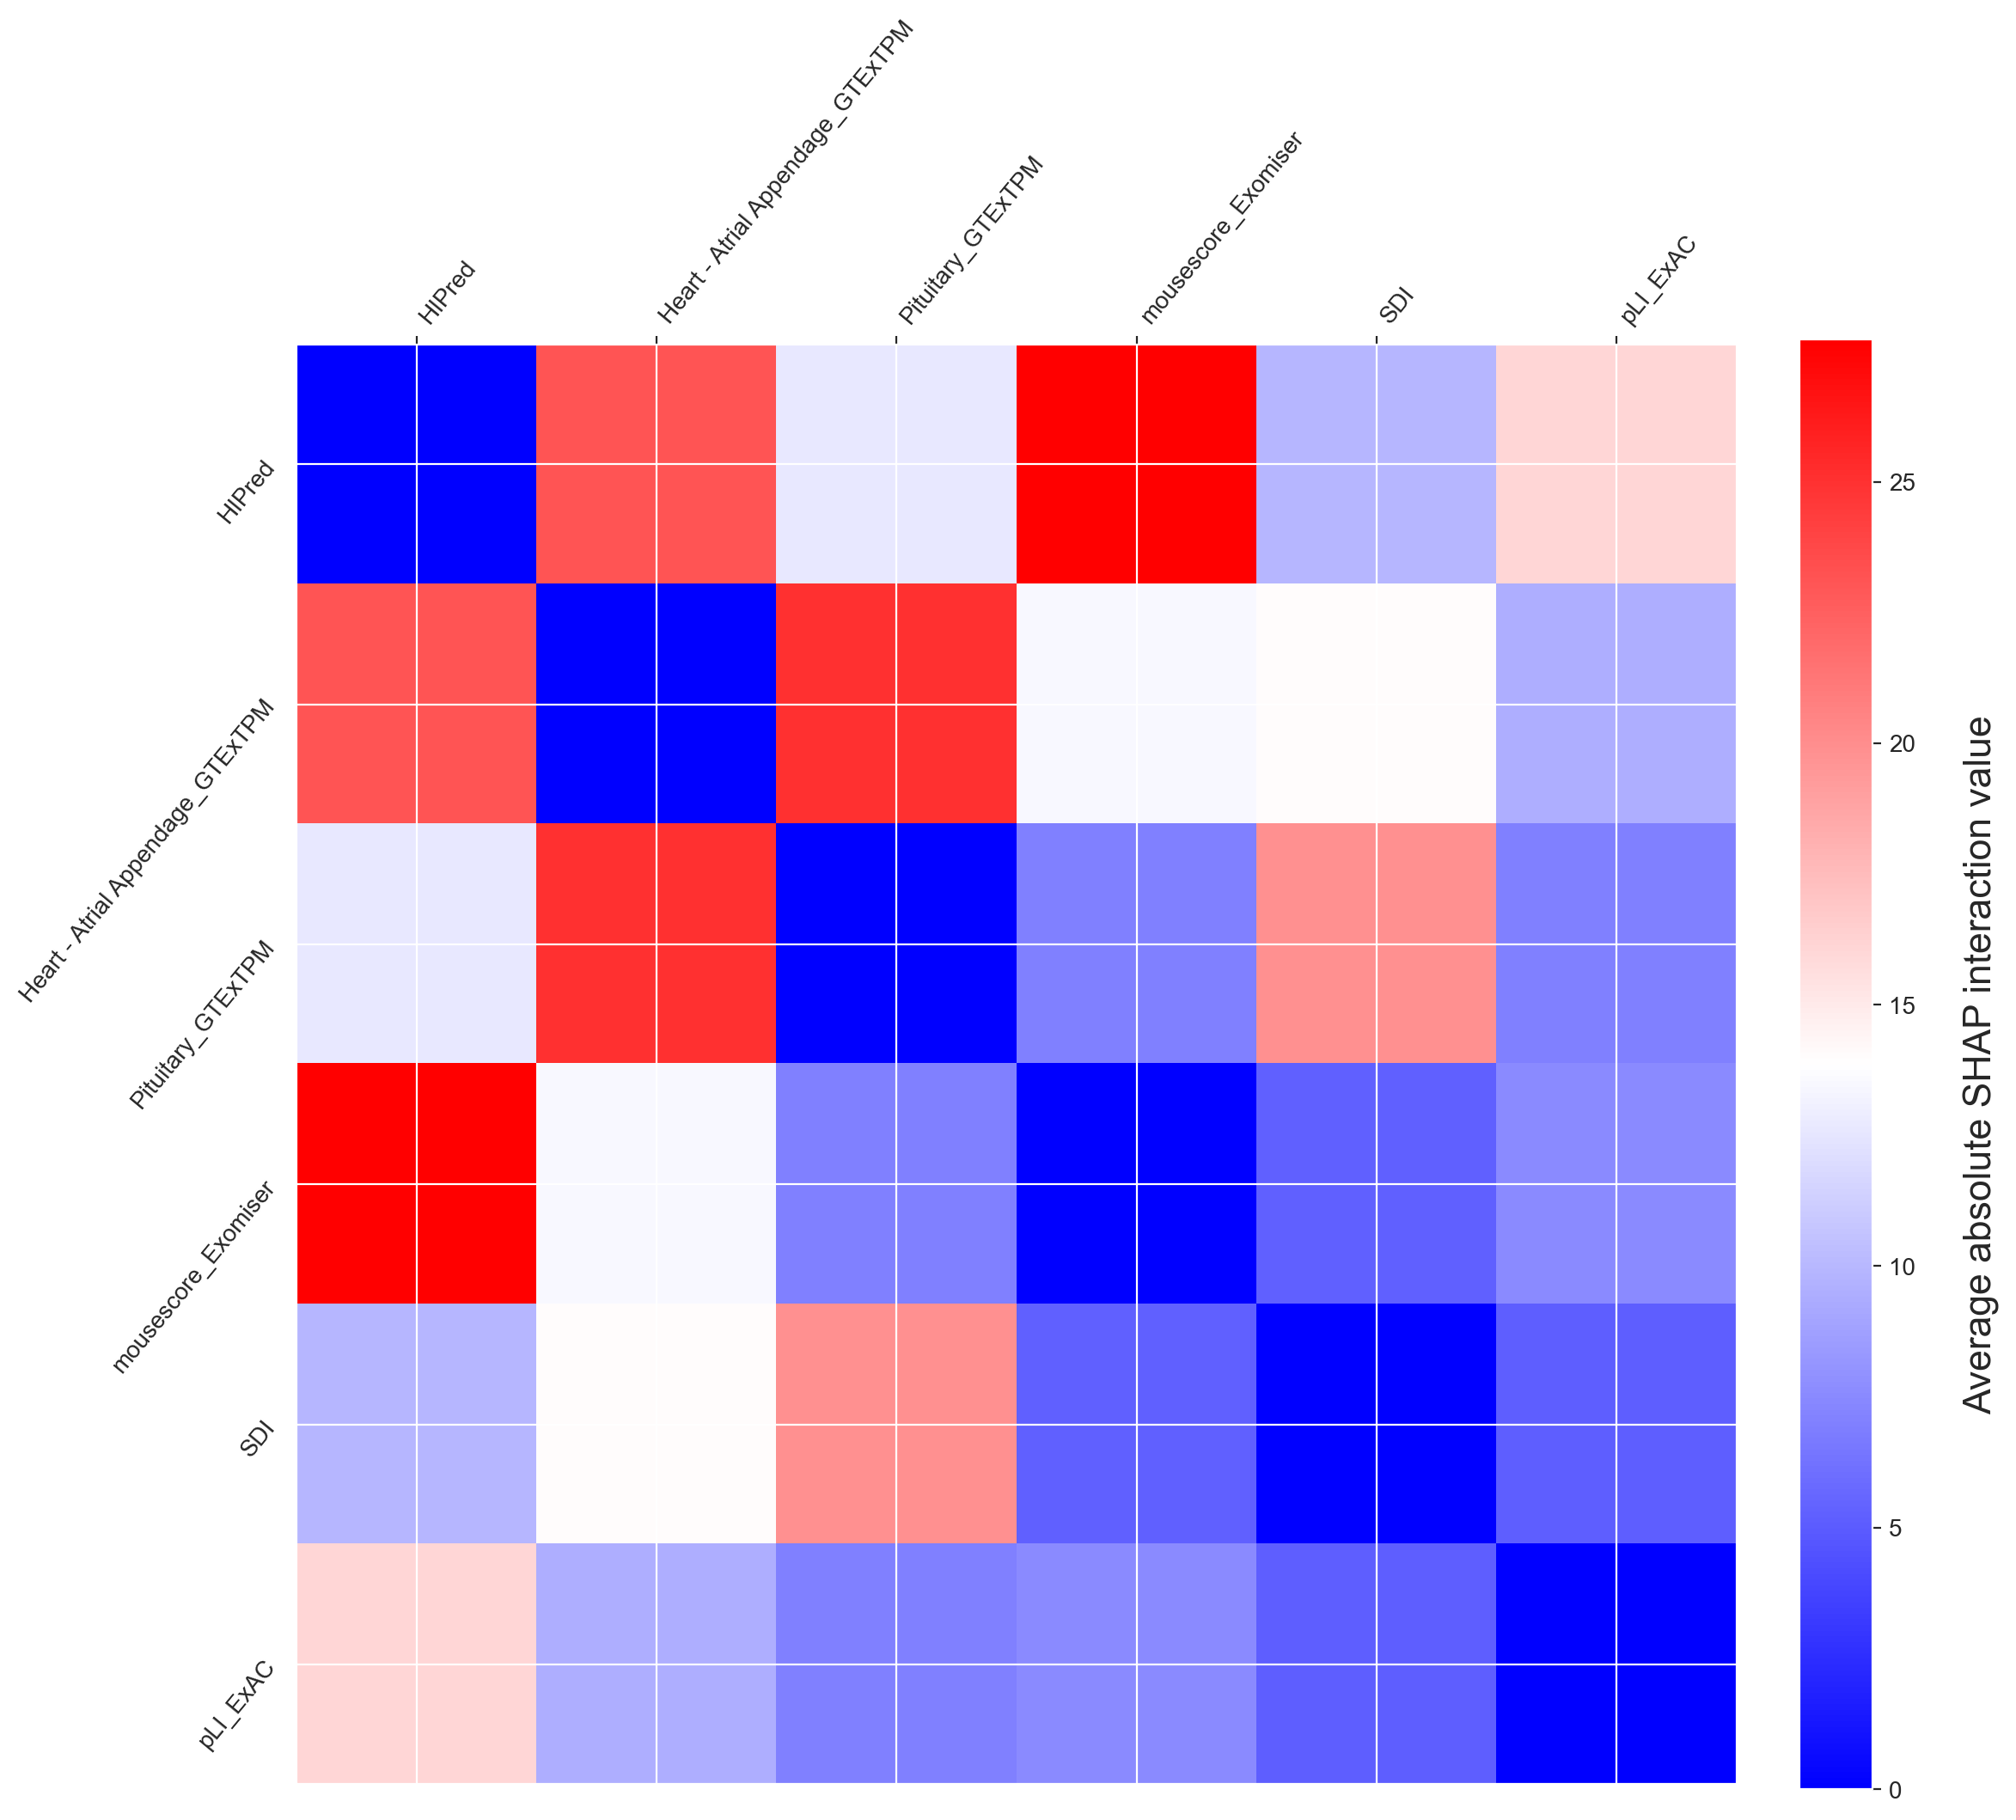

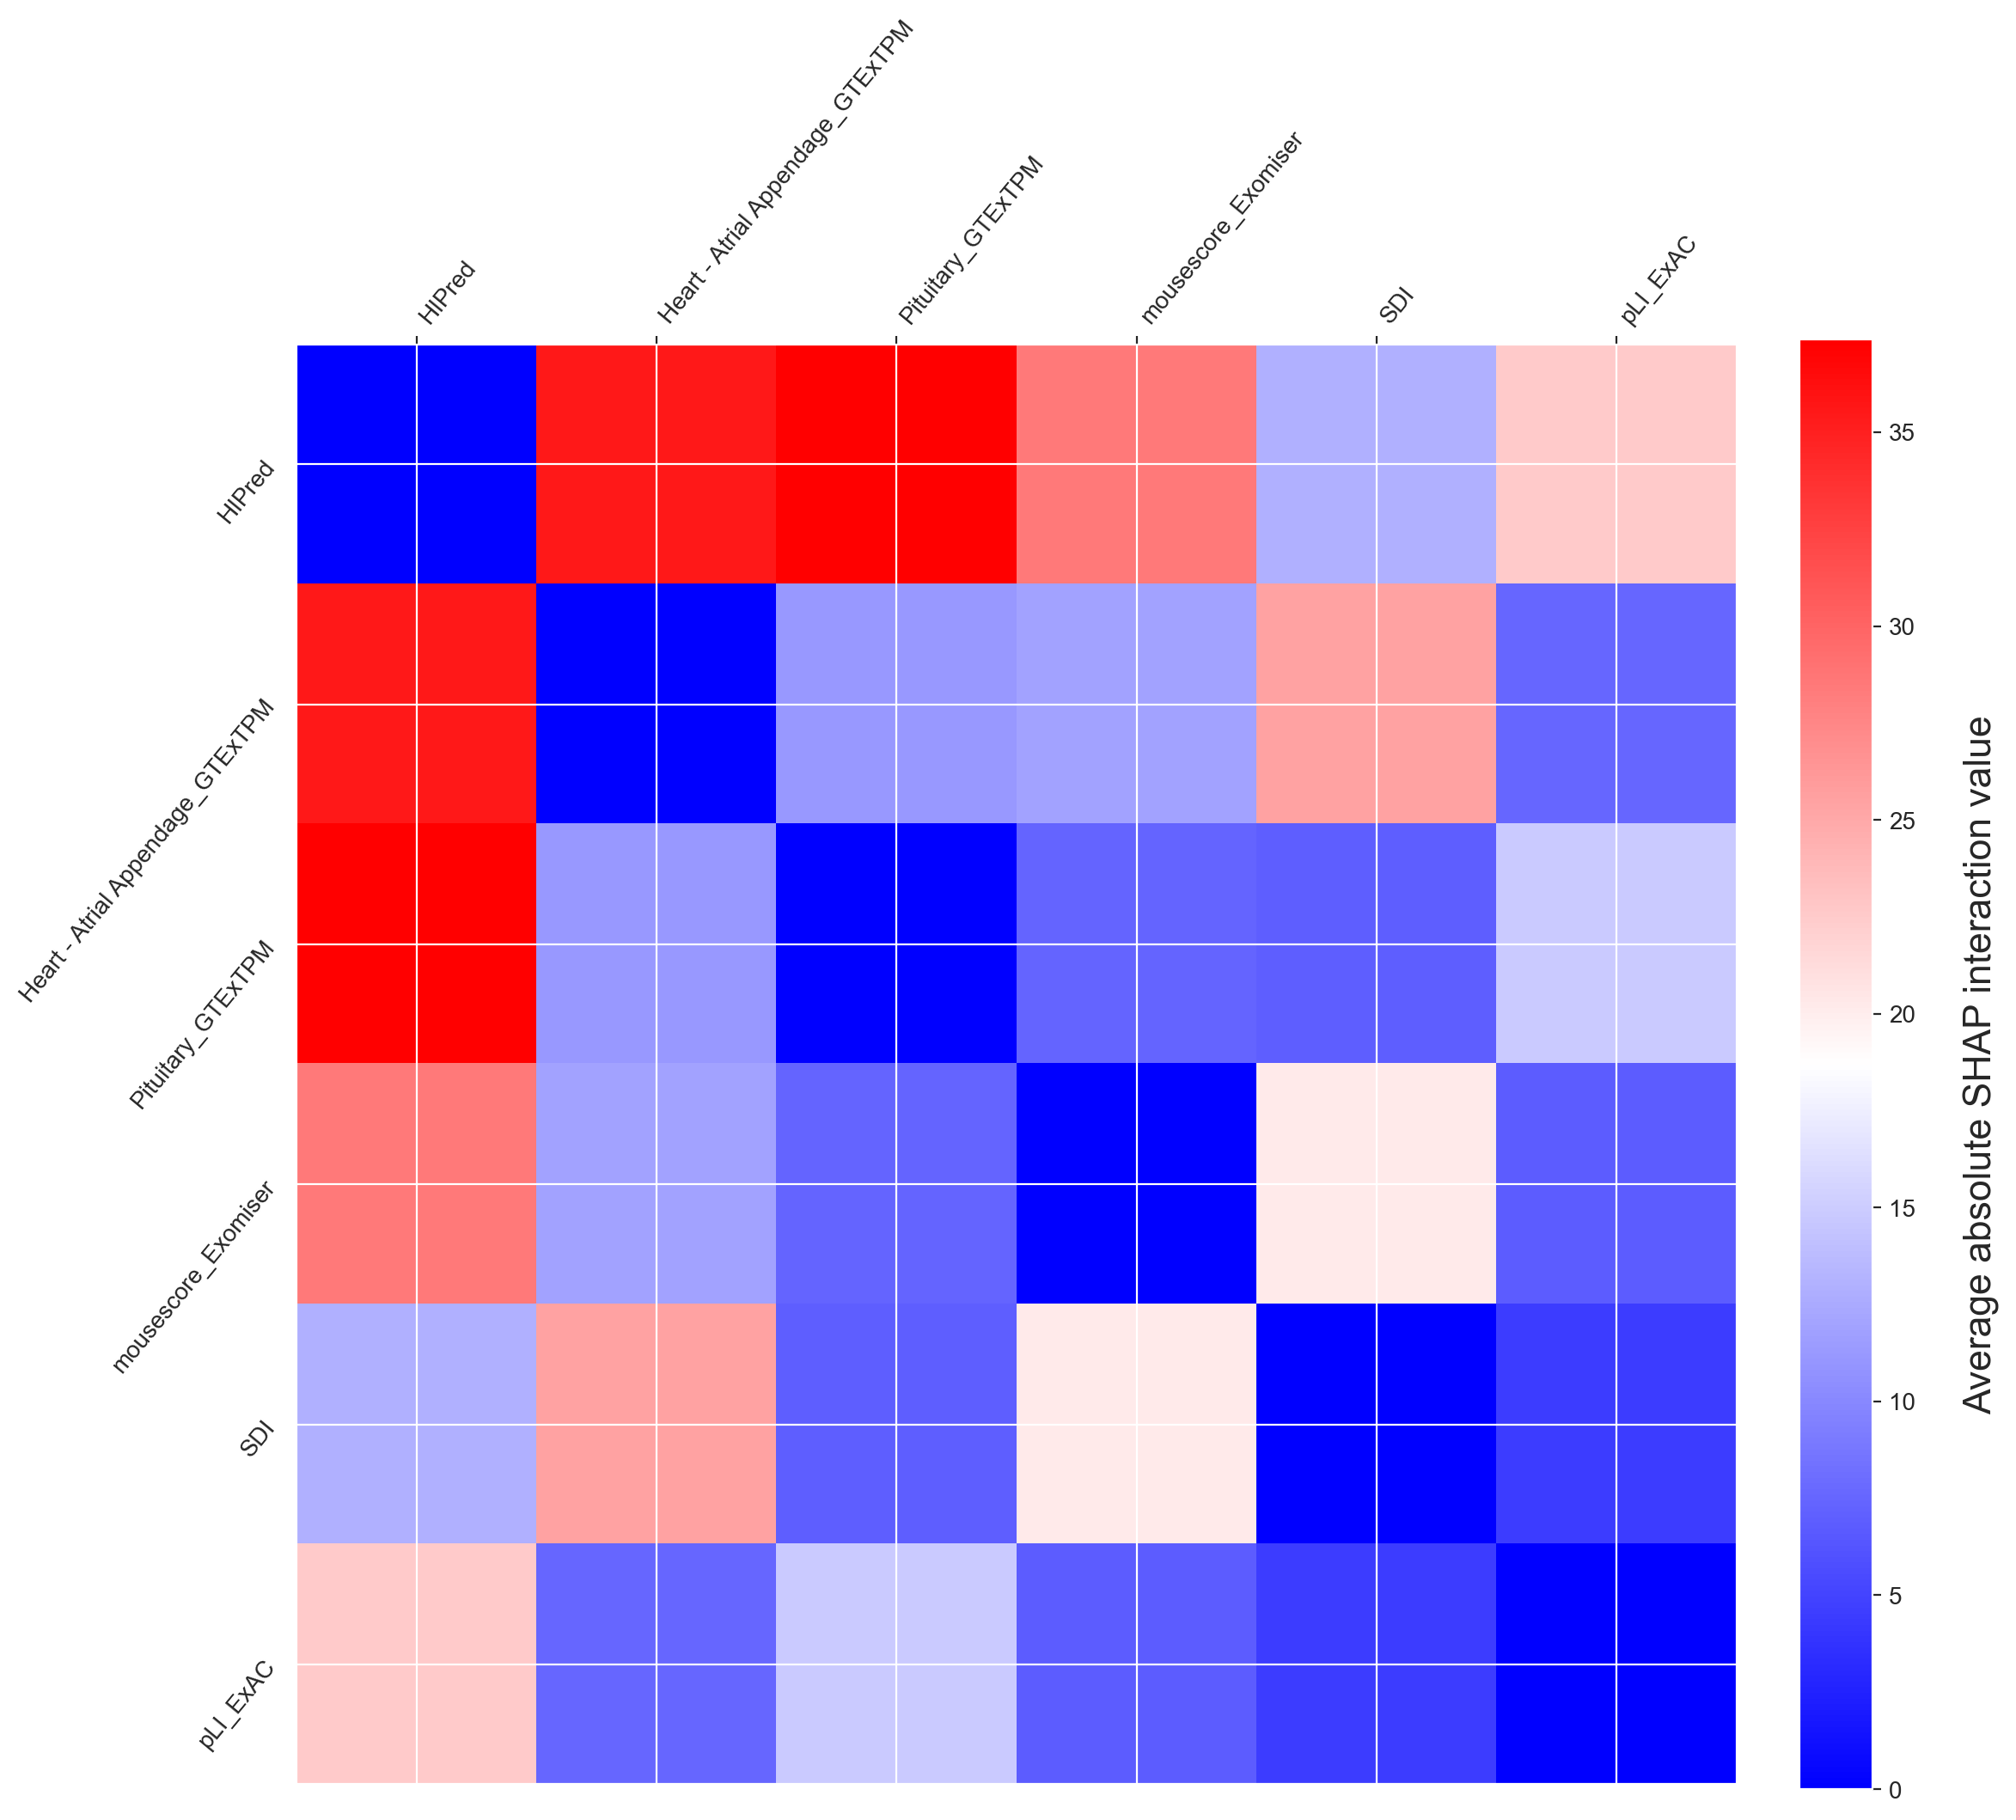

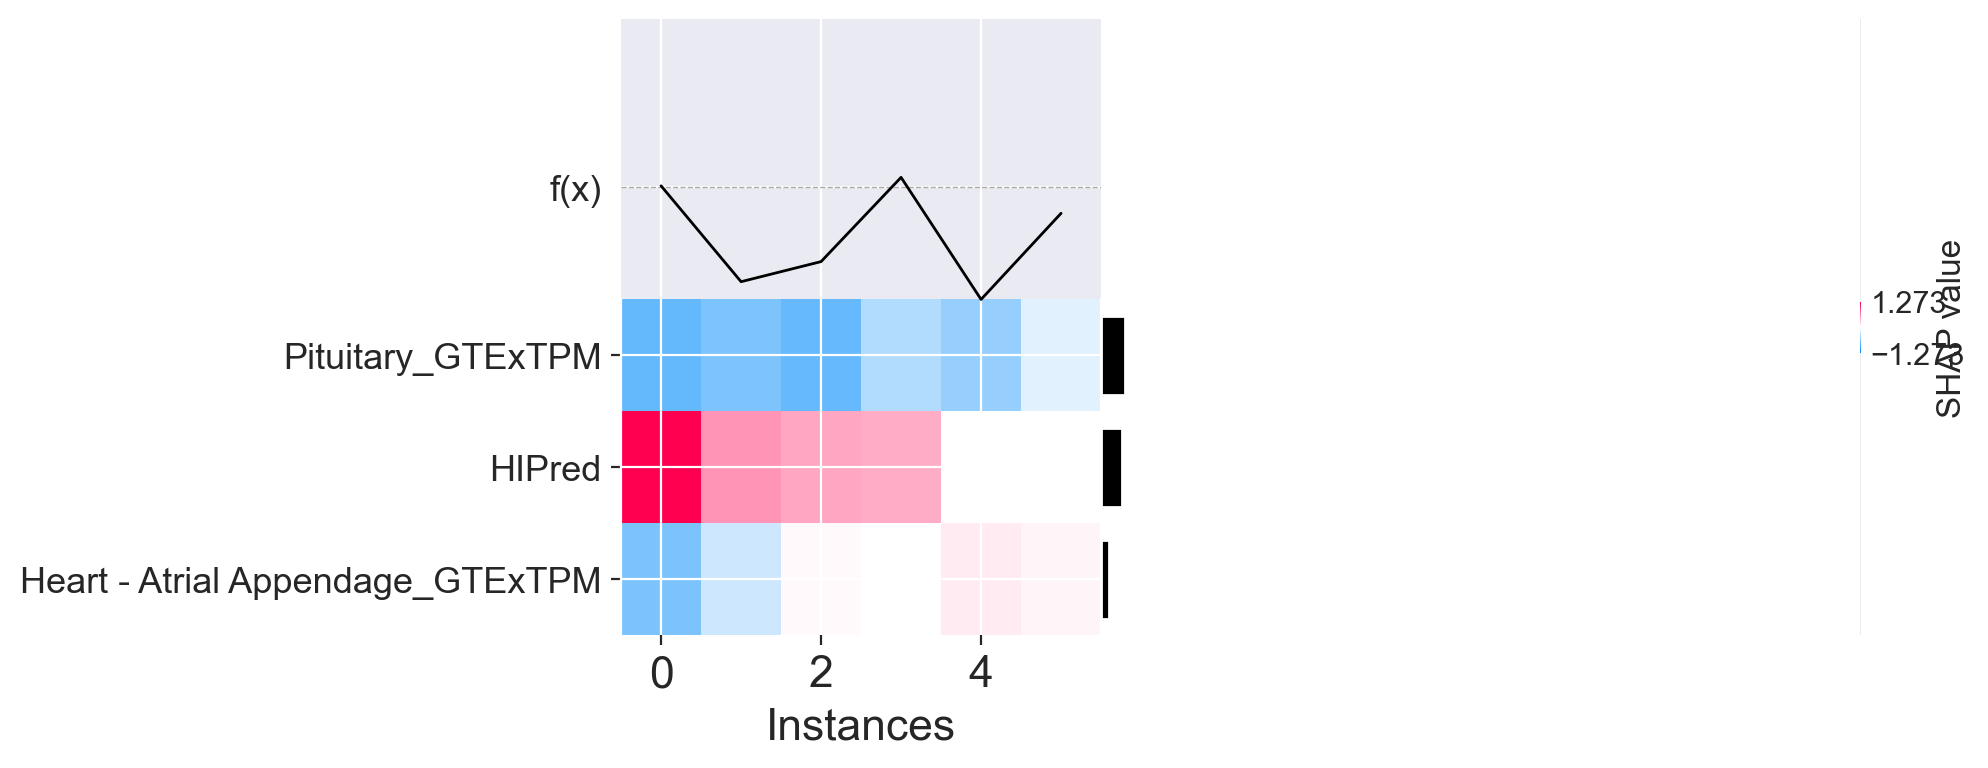

In [33]:
# https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/heatmap.html

shap_values = explainer(X)
fig, ax = plt.subplots()
shap.plots.heatmap(shap_values[0], max_display=6)
fig.savefig('mostlikely_shap_heatmap.svg', format='svg', dpi=1200, bbox_inches = "tight")

In [35]:
select = range(6)
features = X.iloc[select]
features_display = X.loc[features.index]
shap_values = explainer.shap_values(X)


In [36]:
shap.initjs()
shap.force_plot(
    explainer.expected_value[0],
    shap_values[0],
    X.iloc[:293, :],
    features_display,
)

In [37]:
output_of_force_plot = shap.force_plot(
    explainer.expected_value[0],
    shap_values[0],
    X.iloc[:293, :],
    features_display,
)
file = "mostlikely_force_plot.html"
shap.save_html(file, output_of_force_plot)

## Decision Plots:
- The plot is centered on the x-axis at explainer.expected_value. All SHAP values are relative to the model's expected value like a linear model's effects are relative to the intercept.
- The y-axis lists the model's features. By default, the features are ordered by descending importance. The importance is calculated over the observations plotted. _This is usually different than the importance ordering for the entire dataset._ In addition to feature importance ordering, the decision plot also supports hierarchical cluster feature ordering and user-defined feature ordering.
- Each observation's prediction is represented by a colored line. At the top of the plot, each line strikes the x-axis at its corresponding observation's predicted value. This value determines the color of the line on a spectrum.
- Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model's base value. This shows how each feature contributes to the overall prediction.
- At the bottom of the plot, the observations converge at explainer.expected_value.

In [38]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)
expected_value = explainer.expected_value

In [39]:
expected_value

[0.5654536, 0.6671795, 0.29051664]

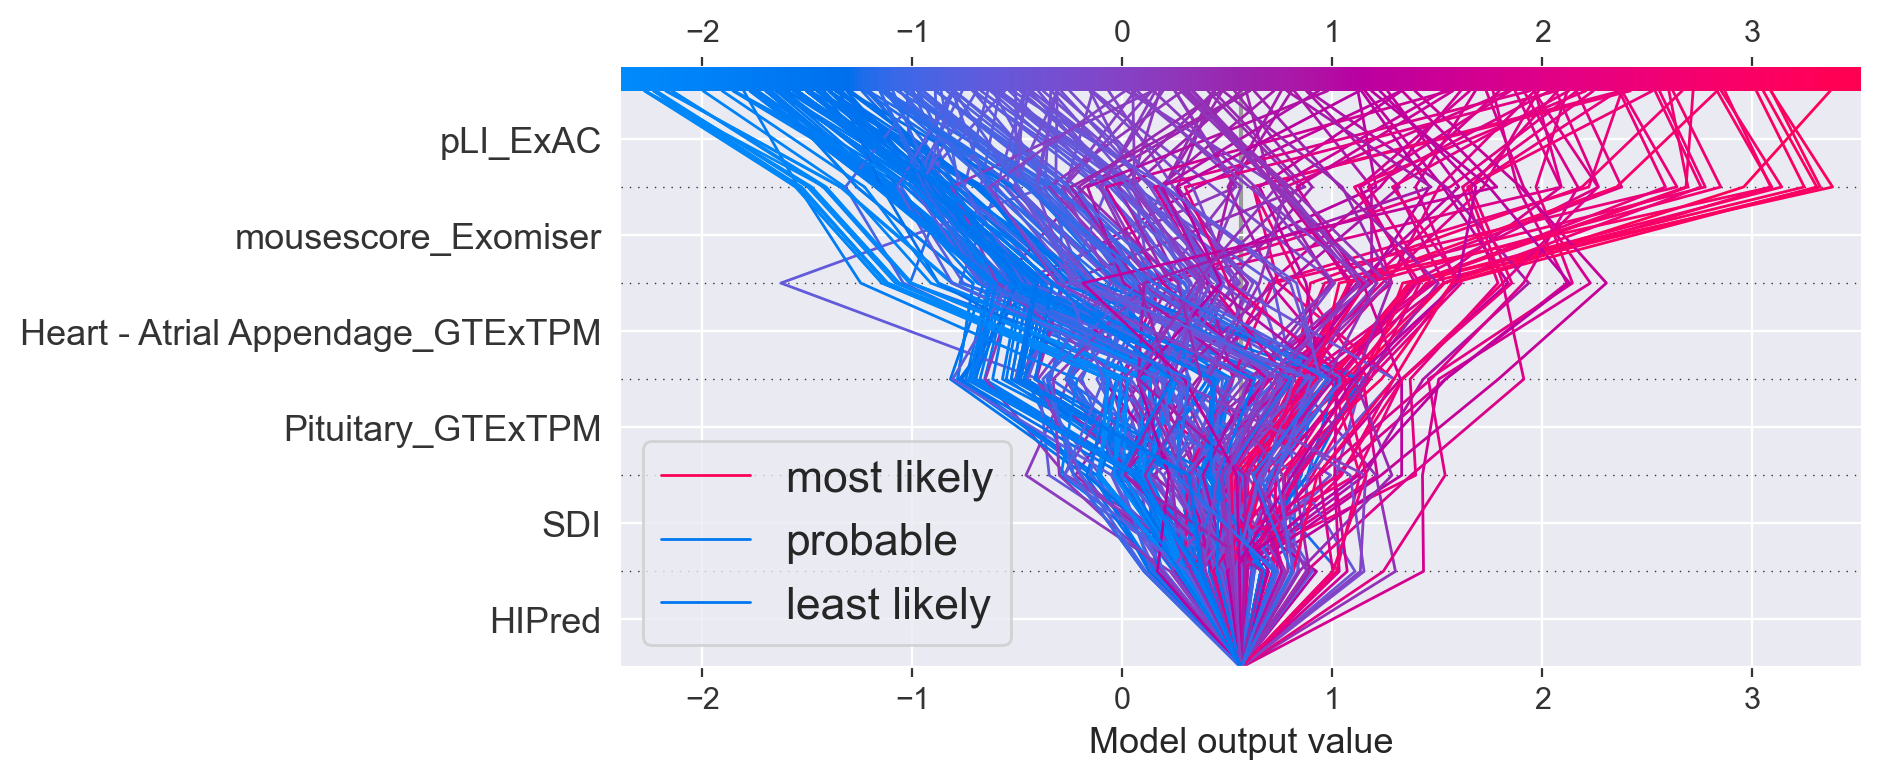

In [40]:
shap.decision_plot(
    expected_value[0],
    shap_values[0],
    feature_names=list(X),
    ignore_warnings=True,
    legend_labels=class_names,
)

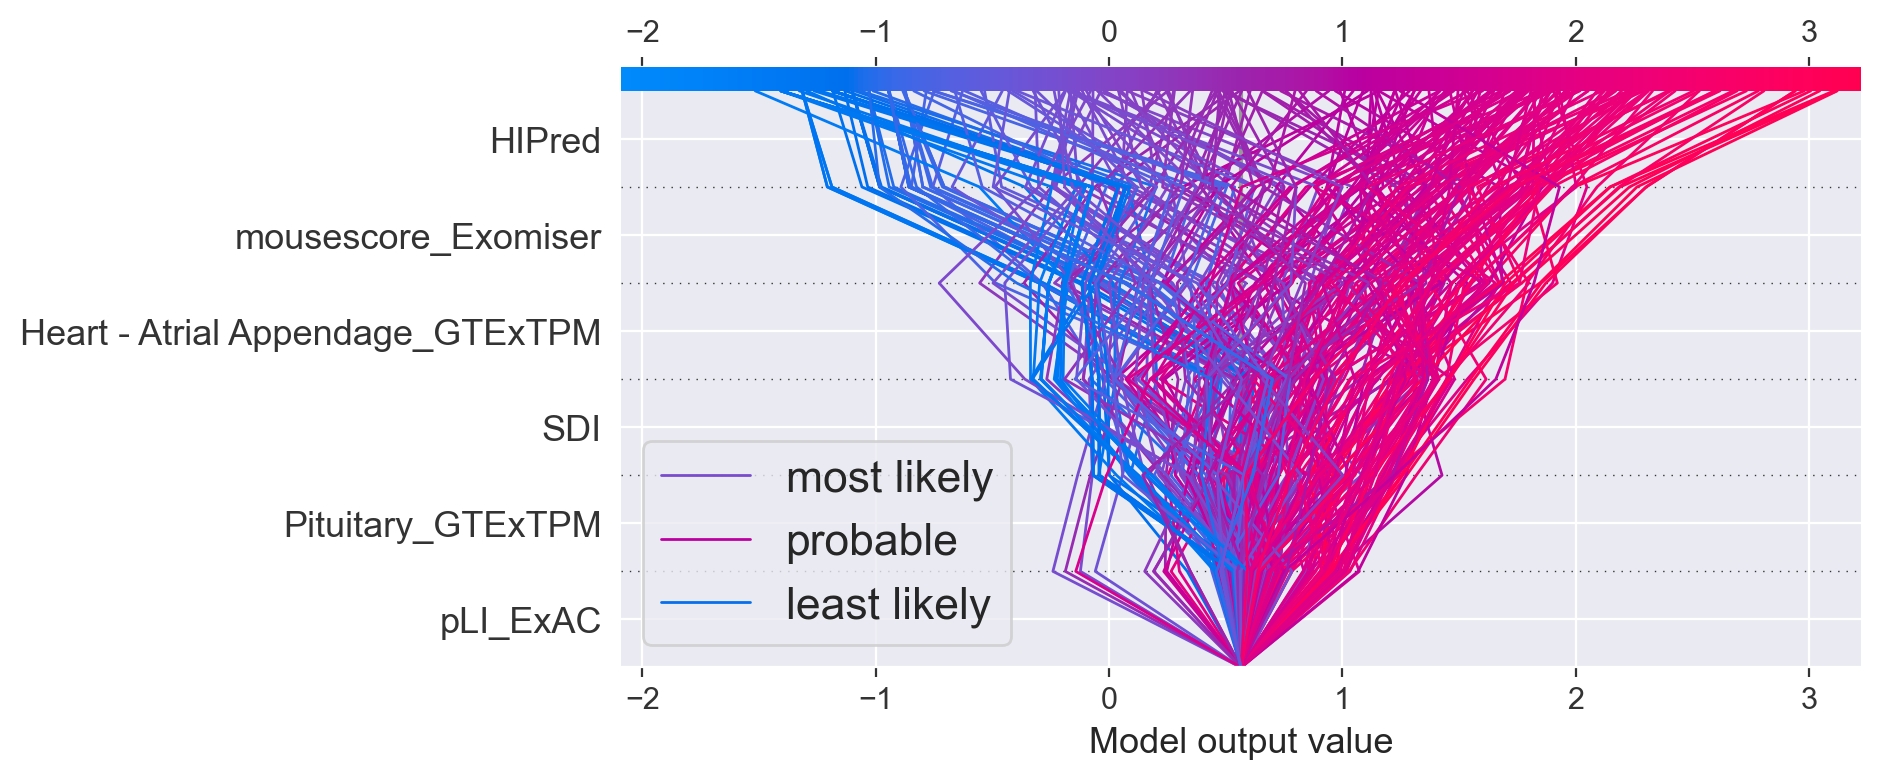

In [41]:
shap.decision_plot(
    expected_value[0],
    shap_values[1],
    feature_names=list(X),
    ignore_warnings=True,
    legend_labels=class_names,
)

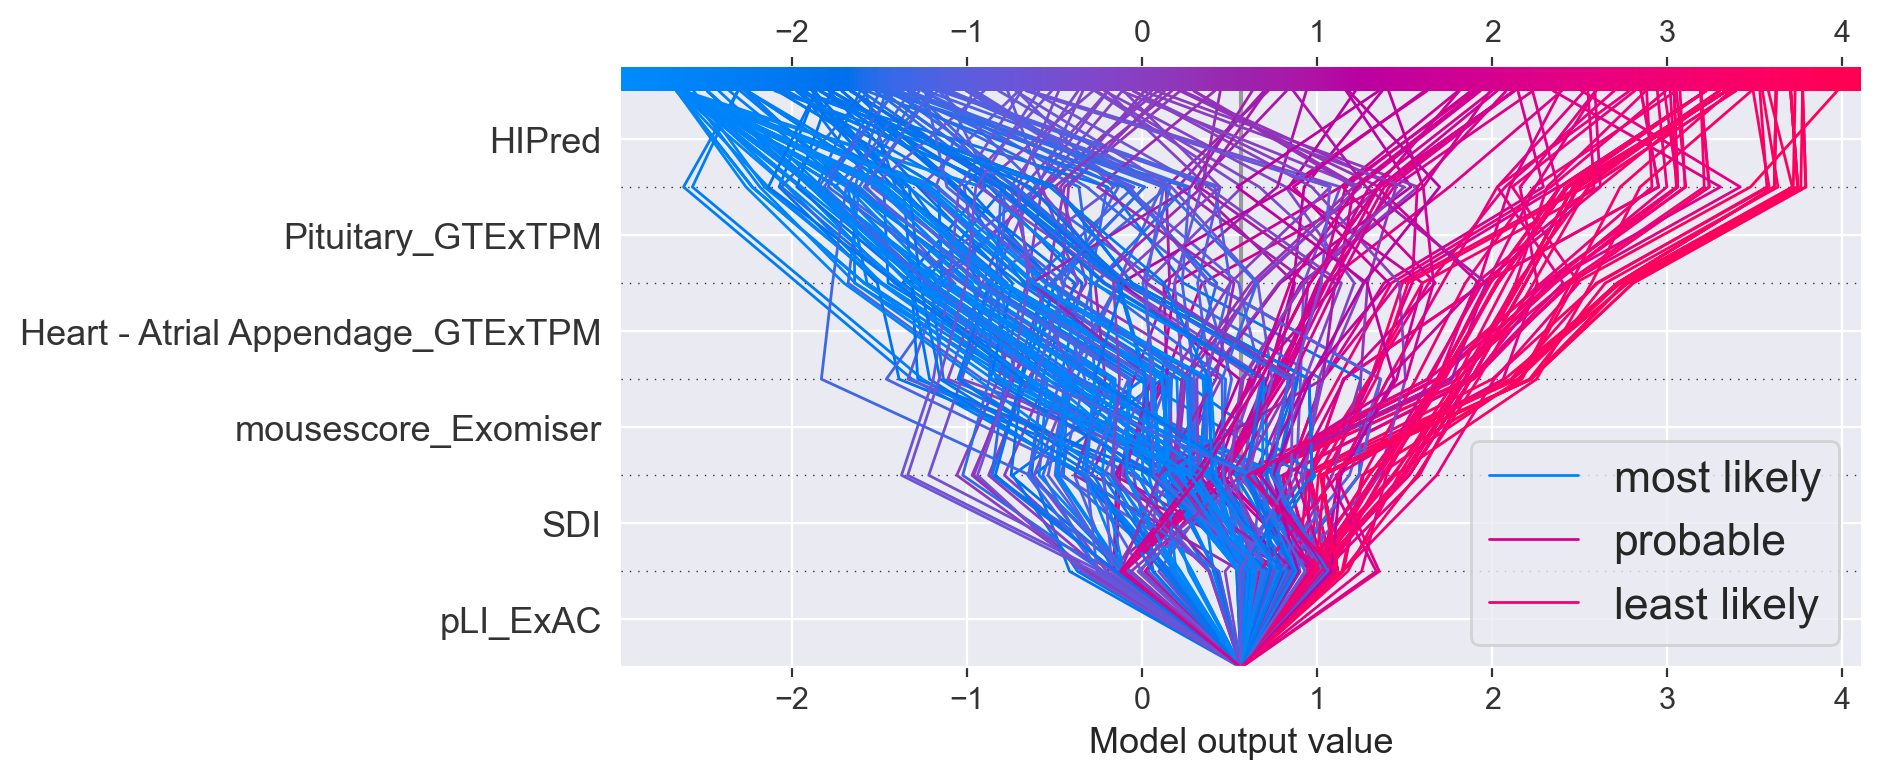

In [42]:
shap.decision_plot(
    expected_value[0],
    shap_values[2],
    feature_names=list(X),
    ignore_warnings=True,
    legend_labels=class_names,
)

# Shap value clustering for most likely gene group

In [43]:
df3 = pd.DataFrame(data=X, columns=X.columns)
df3.columns = [
    regex.sub("_", col) if any(x in str(col) for x in set(("[", "]", "<"))) else col
    for col in X.columns.values
]

explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

In [44]:
features = X.columns.values.tolist()
shapdf = pd.DataFrame(data=np.array(shap_values[0]), columns=features)
#shapdf["shap_average"] = shapdf.mean(axis=1)
shapdf

HIPred  Heart - Atrial Appendage_GTExTPM  Pituitary_GTExTPM  \
0   -0.008284                          0.440674           0.536480   
1   -0.185077                          0.116560          -0.754751   
2   -0.209431                          0.103877          -0.759942   
3   -0.210069                          0.123615          -0.772475   
4   -0.207374                          0.103873          -0.791447   
..        ...                               ...                ...   
288 -0.033599                          0.489603           0.182158   
289 -0.210069                          0.103873          -0.790337   
290  0.240517                         -0.824973           0.353260   
291 -0.213826                          0.103483          -0.790337   
292 -0.184439                          0.079035          -0.805045   

     mousescore_Exomiser       SDI  pLI_ExAC  
0               1.424045  0.000709  0.412541  
1              -0.550902 -0.303585 -0.535981  
2              -0.532072 -0.062130 -0.609706  
3              -0.550134 -0.303585 -0.549983  
4              -0.550221 -0.268557 -0.603001  
..                   ...       ...       ...  
288            -0.565522 -0.032405 -0.558989  
289            -0.550134 -0.294014 -0.598072  
290            -0.606886 -0.183547 -0.692266  
291            -0.550134 -0.267841 -0.598072  
292            -0.474235 -0.062351 -0.573473  

[293 rows x 6 columns]

In [45]:
from sklearn.cluster import AgglomerativeClustering 
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import scipy.cluster.hierarchy as shc


pca = PCA(n_components = 4) 
X_principal = pca.fit_transform(shapdf) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2', 'P3', 'P4'] 

In [46]:
mean_vec = np.mean(shapdf, axis=0)
cov_mat = (shapdf - mean_vec).T.dot((shapdf - mean_vec)) / (shapdf.shape[0] - 1)

eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print("Eigenvectors \n%s" % eig_vecs)
print("\nEigenvalues \n%s" % eig_vals)


# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:, i]) for i in range(len(eig_vals))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)
tot = sum(eig_vals)
var_exp = [(i / tot) * 100 for i in sorted(eig_vals, reverse=True)]
len(var_exp)

sns.set(font_scale=1)
plt.figure(figsize=(6, 4))

plt.bar(
    range(6), var_exp, alpha=0.5, align="center", label="individual explained variance"
)
plt.ylabel("Explained variance ratio")
plt.xlabel("Principal components")
plt.legend(loc="best")
plt.tight_layout()

print(var_exp)

Eigenvectors 
[[ 0.08167642  0.05193585 -0.98304063 -0.14365293 -0.0595609  -0.00888979]
 [ 0.53953224 -0.7591849   0.04223637 -0.3220587   0.14634115  0.07497842]
 [ 0.11625102  0.49282676  0.13300613 -0.7939338   0.29493076  0.09274598]
 [ 0.7050605   0.3382965   0.04787571  0.24337216 -0.03009489 -0.57097936]
 [ 0.09547747  0.02399767  0.10881269 -0.29517645 -0.94186246  0.06506842]
 [ 0.42719245  0.25108233 -0.00492326  0.3145663   0.00648025  0.80959624]]

Eigenvalues 
[0.47968847 0.33763966 0.04252918 0.10667422 0.063352   0.24454585]
[37.63947041658733, 26.49339913736671, 19.18865438824977, 8.370351992270704, 4.971008809772362, 3.3371152557531305]


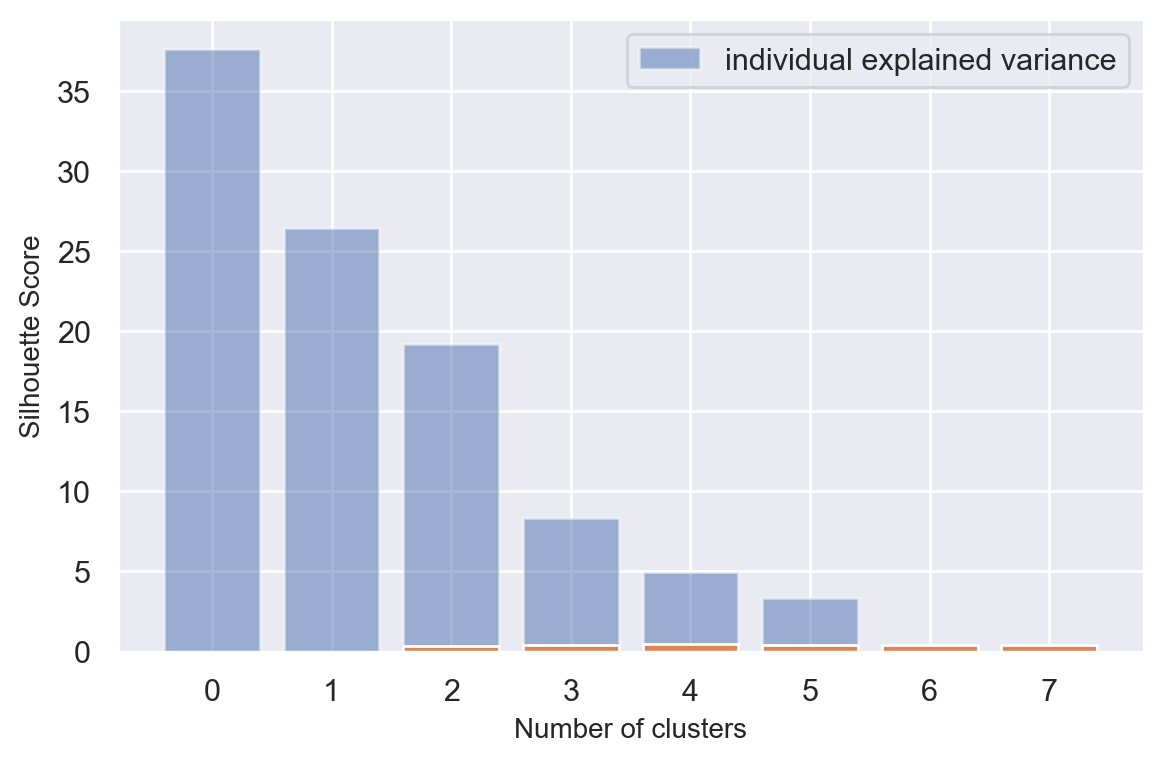

In [47]:
silhouette_scores = [] 

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(X_principal, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(X_principal))) 
    
# Plotting a bar graph to compare the results 
k = [2, 3, 4, 5, 6,7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

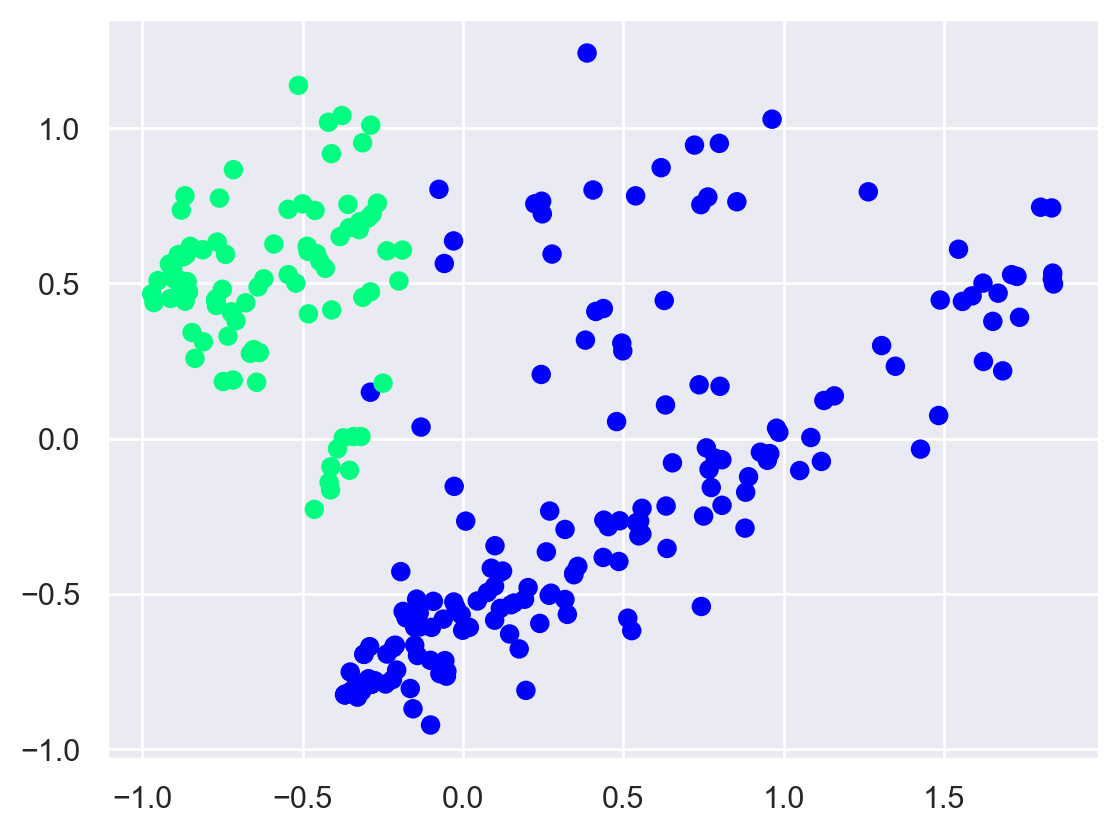

In [48]:
agg = AgglomerativeClustering(n_clusters=2)
agg.fit(X_principal)

sns.set(font_scale=1)
plt.scatter(
    X_principal["P1"],
    X_principal["P2"],
    c=AgglomerativeClustering(n_clusters=2).fit_predict(X_principal),
    cmap=plt.cm.winter,
)
plt.show()

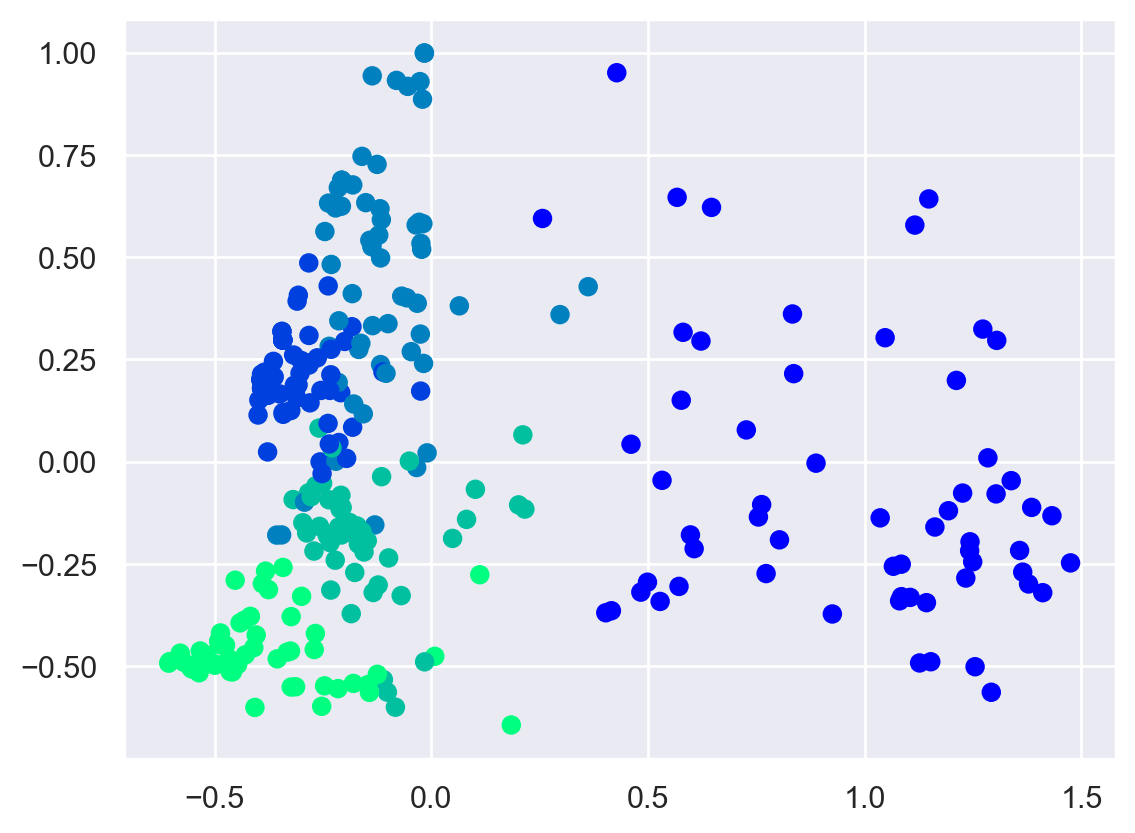

In [264]:
agg = AgglomerativeClustering(n_clusters=5)
agg.fit(X_principal)

sns.set(font_scale=1)
plt.scatter(
    X_principal["P1"],
    X_principal["P2"],
    c=AgglomerativeClustering(n_clusters=5).fit_predict(X_principal),
    cmap=plt.cm.winter,
)
plt.show()

## Unknown Gene Prediction

In [49]:
dataset_unknown = pd.read_csv("3l_predicted_data.txt", sep="\t")

df2 = dataset_unknown[
    [
       'HIPred', 'Heart - Atrial Appendage_GTExTPM', 'Pituitary_GTExTPM', 'mousescore_Exomiser', 'SDI', 'pLI_ExAC'
    ]
]

df2.shape

(1804, 6)

In [50]:
imputer = MissForest(random_state=seed)
df3 = imputer.fit_transform(df2)

Iteration: 0
Iteration: 1


In [51]:
X2 = pd.DataFrame(df3, index=df2.index, columns=df2.columns)

X2.shape

(1804, 6)

In [53]:
model = xgb

#model.fit(X, Y, sample_weight=classes_weights_all)
predictions = list(xgb.predict(X2))

output = pd.Series(data=predictions, index=dataset_unknown.index, name="cb_label")

df_total = pd.concat([dataset_unknown, output], axis=1)

In [55]:
class_preds =  list(model.predict(X2))


output = pd.Series(data=class_preds, index=dataset_unknown['Gene'], name="xgb_label")

output = output.to_frame()
output.reset_index(level=0, inplace=True)

output.to_csv('XGB_predictions_3_classes.csv')

In [56]:
output = pd.Series(data=class_preds, name="xgb_label")

df_hipred = pd.concat([dataset_unknown, output], axis=1)

In [57]:
predictions =  list(model.predict_proba(X2))
predictions = pd.DataFrame(predictions, columns=['most likely','probable', 'least likely'])

df_total = pd.concat([dataset_unknown, predictions], axis=1)

In [58]:
df_total
df_file = df_total[["Gene","HIPred", "most likely", "probable", "least likely"]]
df_file.to_csv('HIPREDthree_label_preds.csv')

In [59]:
df_total.nlargest(10, "most likely", keep="last")

Gene  REVEL.max  MetaSVM_rankscore.max  MetaLR_rankscore.max  \
534   FILIP1L        NaN                    NaN                   NaN   
854     MRVI1      0.054                  0.373                 0.031   
303      CHD2        NaN                    NaN                   NaN   
718    KLHL21        NaN                    NaN                   NaN   
1487   SLC4A7        NaN                    NaN                   NaN   
505     FBLN5        NaN                    NaN                   NaN   
872     MYH11      0.198                  0.444                 0.147   
179     BNIP3        NaN                    NaN                   NaN   
362     CSRP3        NaN                    NaN                   NaN   
237     CASZ1        NaN                    NaN                   NaN   

      MCAP.max  wgEncodeBroadHmmHuvecHMM.count  betamax  logpval_gwascatalog  \
534        NaN                             113  -0.2155            18.397940   
854        NaN                             409  -0.5660            53.000000   
303        NaN                            1661   0.4032            16.301030   
718        NaN                             232  -0.4014            22.301030   
1487       NaN                              67   0.5334            44.522879   
505        NaN                              21   0.1491            14.522879   
872        NaN                             128  -0.4460            17.000000   
179        NaN                             241  -0.7551            14.000000   
362        NaN                             591   0.3833            10.397940   
237        NaN                               1      NaN            75.522879   

      Adipose - Subcutaneous_GTExTPM  Adipose - Visceral (Omentum)_GTExTPM  \
534                        48.880400                             36.398500   
854                        41.753100                             19.800600   
303                        25.618800                             20.182700   
718                        31.969600                             25.748600   
1487                       13.741500                             10.103700   
505                       110.216000                            148.665000   
872                       180.013000                             78.924200   
179                        38.921800                             30.626400   
362                         0.196411                              0.188677   
237                         3.192030                              2.675640   

      ...  MutationAssessor_rankscore  REVEL_score  fathmm-MKL_coding_score  \
534   ...                         NaN          NaN                      NaN   
854   ...                         NaN        0.137                  0.92385   
303   ...                         NaN          NaN                      NaN   
718   ...                         NaN        0.040                  0.04192   
1487  ...                         NaN          NaN                      NaN   
505   ...                         NaN          NaN                      NaN   
872   ...                         NaN          NaN                      NaN   
179   ...                         NaN          NaN                      NaN   
362   ...                         NaN          NaN                      NaN   
237   ...                         NaN          NaN                      NaN   

      integrated_fitCons_rankscore  LoFtool  GERP_Rankscore  BPlabel  \
534                            NaN   0.9010             NaN  unknown   
854                        0.21443   0.8300         0.94564  unknown   
303                            NaN      NaN             NaN  unknown   
718                        0.31514   0.4220         0.02204  unknown   
1487                           NaN   0.4690             NaN  unknown   
505                            NaN   0.8710             NaN  unknown   
872                            NaN   0.0802             NaN  unknown   
179                

In [60]:
df_total.nlargest(10, "probable", keep="last")

Gene  REVEL.max  MetaSVM_rankscore.max  MetaLR_rankscore.max  \
1597  TFCP2L1        NaN                    NaN                   NaN   
462    ELAVL3        NaN                    NaN                   NaN   
1203    REEP1        NaN                    NaN                   NaN   
186      BTRC        NaN                    NaN                   NaN   
5        ABI2        NaN                    NaN                   NaN   
1525    SPC25      0.224                  0.458                 0.000   
1575     TAF5        NaN                    NaN                   NaN   
1485  SLC4A10        NaN                    NaN                   NaN   
522       FER      0.087                  0.343                 0.081   
841    MPPED2        NaN                    NaN                   NaN   

      MCAP.max  wgEncodeBroadHmmHuvecHMM.count  betamax  logpval_gwascatalog  \
1597       NaN                             499   0.2960            27.000000   
462        NaN                               2  -0.2010             7.397940   
1203       NaN                             391   0.8305             9.522879   
186        NaN                             574  -0.3929            15.397940   
5          NaN                            2480  -0.3880            17.397940   
1525       NaN                             686  -0.4537            36.522879   
1575       NaN                            1234  -0.3659            17.096910   
1485       NaN                              19  -0.4288            36.698970   
522        NaN                             137  -0.6099            42.096910   
841        NaN                             462  -0.3409            17.522879   

      Adipose - Subcutaneous_GTExTPM  Adipose - Visceral (Omentum)_GTExTPM  \
1597                        1.735520                              0.913285   
462                         0.050540                              0.055920   
1203                        3.255300                              4.418150   
186                         7.751240                              8.139200   
5                           7.948130                              7.780280   
1525                        0.534749                              0.603769   
1575                        4.598660                              4.118080   
1485                        0.051130                              0.051856   
522                         6.563870                              5.012250   
841                         1.072720                              0.968080   

      ...  MutationAssessor_rankscore  REVEL_score  fathmm-MKL_coding_score  \
1597  ...                         NaN          NaN                      NaN   
462   ...                         NaN          NaN                      NaN   
1203  ...                     0.42885        0.934                  0.99159   
186   ...                         NaN          NaN                      NaN   
5     ...                         NaN          NaN                      NaN   
1525  ...                     0.19370        0.174                  0.86988   
1575  ...                         NaN          NaN                      NaN   
1485  ...                     0.51832        0.483                  0.98126   
522   ...                     0.22405        0.066                  0.17170   
841   ...                     0.33814        0.521                  0.98419   

      integrated_fitCons_rankscore  LoFtool  GERP_Rankscore  BPlabel  \
1597                           NaN      NaN             NaN  unknown   
462                            NaN   0.7060             NaN  unknown   
1203                       0.92422   0.3770         0.92740  unknown   
186                            NaN   0.7090             NaN  unknown   
5                              NaN      NaN             NaN  unknown   
1525                       0.49399   0.7930         0.92413  unknown   
1575                           NaN   0.5310             NaN  unknown   
1485               

In [61]:
df_total.nlargest(10, "least likely", keep="last")

Gene  REVEL.max  MetaSVM_rankscore.max  \
1028                OR8K1      0.081                  0.440   
1019                OR5W2      0.149                  0.466   
1008                OR5F1      0.077                  0.412   
941                OR11A1      0.134                  0.619   
1799              ZNF92P2        NaN                    NaN   
1751              ZBED1P1        NaN                    NaN   
1741  XXbac-BPGBPG24O18.1        NaN                    NaN   
1716              VN1R11P        NaN                    NaN   
1702              UQCRHP1        NaN                    NaN   
1689               UBTFL7        NaN                    NaN   

      MetaLR_rankscore.max  MCAP.max  wgEncodeBroadHmmHuvecHMM.count  betamax  \
1028                 0.000       NaN                              51   0.1792   
1019                 0.000       NaN                              30  -0.3632   
1008                 0.091       NaN                             145   0.3040   
941                  0.021       NaN                             433  -0.2712   
1799                   NaN       NaN                              10   0.2253   
1751                   NaN       NaN                              92   0.2428   
1741                   NaN       NaN                              42   0.2681   
1716                   NaN       NaN                              53  -0.1815   
1702                   NaN       NaN                              91   0.2101   
1689                   NaN       NaN                              66   0.5336   

      logpval_gwascatalog  Adipose - Subcutaneous_GTExTPM  \
1028                  NaN                             0.0   
1019                  NaN                             0.0   
1008                  NaN                             0.0   
941             12.000000                             0.0   
1799                  NaN                             0.0   
1751            10.096910                             0.0   
1741                  NaN                             0.0   
1716            26.045757                             0.0   
1702            55.154902                             0.0   
1689             5.154902                             0.0   

      Adipose - Visceral (Omentum)_GTExTPM  ...  MutationAssessor_rankscore  \
1028                                   0.0  ...                         NaN   
1019                                   0.0  ...                         NaN   
1008                                   0.0  ...                         NaN   
941                                    0.0  ...                     0.55661   
1799                                   0.0  ...                     0.45129   
1751                                   0.0  ...                         NaN   
1741                                   0.0  ...                         NaN   
1716                                   0.0  ...                         NaN   
1702                                   0.0  ...                     0.20218   
1689                                   0.0  ...                         NaN   

      REVEL_score  fathmm-MKL_coding_score  integrated_fitCons_rankscore  \
1028          NaN                      NaN                           NaN   
1019          NaN                      NaN                           NaN   
1008          NaN                      NaN                           NaN   
941         0.116                  0.34345                       0.14033   
1799        0.012                  0.01656                       0.14033   
1751          NaN                      NaN                           NaN   
1741          NaN                      NaN                           NaN   
1716          NaN                      NaN                           NaN   
1702        0.025                  0.00585                       0.32371   
1689          NaN                      NaN                           NaN   

      LoFtool  GERP_Rankscore  BPlabel  most likely  pro

In [62]:
df_file = df_total[["Gene", "most likely", "probable", "least likely"]]
df_file = df_file.nlargest(1804, "least likely", keep="last")

In [63]:
df_file

Gene  most likely  probable  least likely
1019         OR5W2     0.005303  0.013990      0.980708
1028         OR8K1     0.005303  0.013990      0.980708
941         OR11A1     0.005303  0.013990      0.980708
1008         OR5F1     0.005303  0.013990      0.980708
1357  RP11-707M1.7     0.004917  0.015487      0.979597
...            ...          ...       ...           ...
1506          SMOX     0.044450  0.953588      0.001962
697         KANSL1     0.031480  0.966671      0.001849
186           BTRC     0.013489  0.984751      0.001760
1203         REEP1     0.013489  0.984751      0.001760
5             ABI2     0.013489  0.984751      0.001760

[1804 rows x 4 columns]

In [64]:
df_file.to_csv('xgb_3_class_probabilties.csv')

### SHAP Feature Importance Visualization:

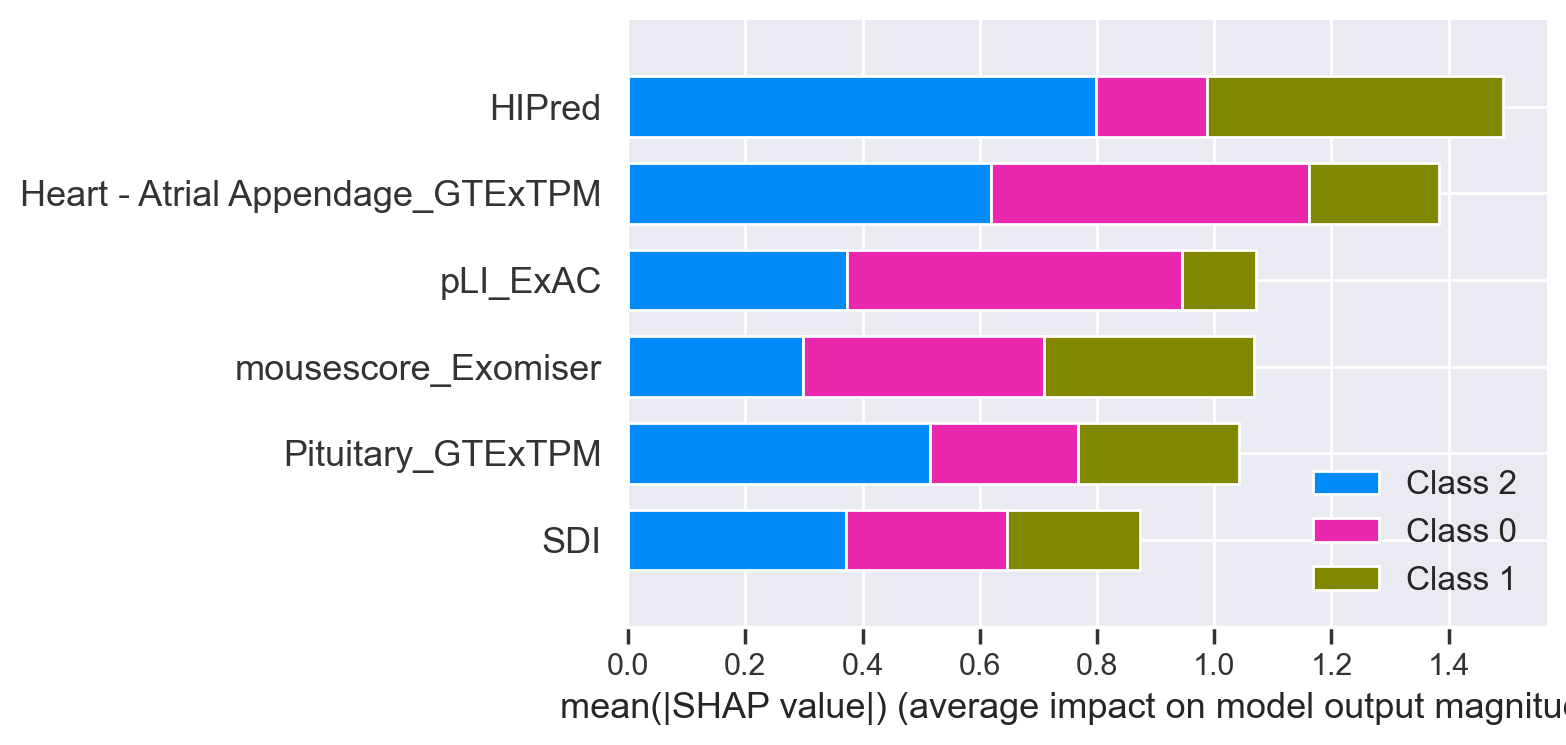

In [74]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)